In [61]:
from collections import Counter, OrderedDict
import copy
import glob
from itertools import izip
import os
import subprocess
import tempfile

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration"


In [121]:
regions, all_regions = CLIP_analysis.regions_generator()

def move_name(interval):
    interval.name = interval[12]
    return interval

def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [3]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/fet_family_v4/
!scp -q tscc-login.sdsc.edu:~/projects/fet_family/analysis/fet_family_v4/*.{final.out,metrics,rpkm} /nas3/gpratt/projects/fet_family/analysis/fet_family_v4/

#featureCounts -a /projects/ps-yeolab/genomes/mm9/gencode.vM1.annotation.gtf -o all_counts.txt -M *.bam -T 16
!scp -q tscc-login.sdsc.edu:/home/gpratt/projects/fet_family/analysis/fet_family_v4/all_counts.txt .

scp: /home/gpratt/projects/fet_family/analysis/fet_family_v4/all_counts.txt: No such file or directory


In [4]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/fet_family_v4/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)



fet_clip_filtered = fet_clip[[ "Input Reads",
                            #"Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            ]]

HTML(fet_clip_filtered.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     } ))

In [313]:
all_counts.columns

Index([u'Chr', u'Start', u'End', u'Strand', u'Length', u'20091230_MP1_1_Liver_A1_Saline_RNAseq', u'20091230_MP6_1_Liver_E3_TDP43_knockdown_86%', u'20100210_MP12_1_Striatum_A1_Saline_RNAseq', u'20100210_MP13_1_Striatum_A2_Saline_RNAseq', u'20100210_MP14_1_Striatum_A5_Saline_RNAseq', u'20100210_MP15_1_Striatum_C1_TDP43_knockdown_81%_RNAseq', u'20100210_MP16_1_Striatum_C2_TDP43_knockdown_81%_RNAseq', u'20100210_MP17_1_Striatum_F4_TDP43_knockdown_64%_RNAseq', u'20100305_MP12_2_Striatum_A1_Saline_RNAseq', u'20100305_MP13_2_Striatum_A2_Saline_RNAseq', u'20100305_MP14_2_Striatum_A5_Saline_RNAseq', u'20100305_MP15_2_Striatum_C1_TDP43_knockdown_81%_RNAseq', u'20100305_MP16_2_Striatum_C2_TDP43_knockdown_81%_RNAseq', u'20100305_MP17_2_Striatum_F4_TDP43_knockdown_64%_RNAseq', u'20100305_MP18_1_embryonic_brain_TLS_knockout_RNAseq', u'20100305_MP19_1_embryonic_brain_WT_RNAseq', u'20100307_MP18_2_embryonic_brain_TLS_knockout_RNAseq', u'20100307_MP19_2_embryonic_brain_WT_RNAseq', u'20100307_MP20_1_emb

In [323]:
annotated_qc = pd.merge(fet_clip, metadata, left_index=True, right_on="file_name")

In [332]:
taf15_only_qc = annotated_qc[annotated_qc.analysis_group.isin([2, 3,4]) & annotated_qc.rbp.isin(['TAF15', 'HTT'])]

In [335]:
taf15_only_qc['Uniquely Mapped Reads'].mean()

24817335.0

In [340]:
np.mean([float(item[:-1]) for item in taf15_only_qc['Uniquely mapped reads %']])

85.64222222222223

In [5]:
metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/unix_mouse_fet_data_locations_and_annitations.csv")
metadata = metadata[metadata.geo_name != "not_submitted"]
null_bioreps = metadata[metadata['Biological Replicate'].isnull()]
metadata.loc[null_bioreps.index,'Biological Replicate'] = null_bioreps.Location.apply(lambda x: os.path.basename(x).split(".")[0]).values
metadata['file_name'] = metadata.Location.apply(os.path.basename)
metadata['file_name'] = metadata.file_name.apply(lambda x: x.split(".")[0])
technicalrep_info = metadata.copy()
technicalrep_info.index = technicalrep_info.file_name

biorep_info = metadata.groupby('Biological Replicate').first()

all_counts = pd.read_table("all_counts.txt", index_col=0, skiprows=1)
all_counts.columns = [item.split(".")[0] for item in all_counts.columns]
rpkm = counts_to_rpkm(all_counts)
rpkm = rpkm.T
rpkm = rpkm.ix[biorep_info.index]
flotilla_rpkm = rpkm.copy()

result = []
for index in rpkm.index:
    exp_info = biorep_info.ix[index] 
    result.append([exp_info['rbp'], exp_info['Cell Type'], exp_info['bio_rep'], exp_info['analysis_group'], biorep_info.ix[index].name])
rpkm.index = pd.MultiIndex.from_tuples(result, names=['knockdown', 'cell_type', 'rep', 'analysis_group', 'exp'])
rpkm = rpkm.sortlevel()

In [6]:
result = []
fet_clip_filtered = fet_clip_filtered.ix[technicalrep_info.index]
for index in fet_clip_filtered.index:
    exp_info = technicalrep_info.ix[index] 
    result.append([exp_info['rbp'], exp_info['Cell Type'], exp_info['bio_rep'], exp_info['analysis_group'], technicalrep_info.ix[index].name])
fet_clip_filtered.index = pd.MultiIndex.from_tuples(result, names=['knockdown', 'cell_type', 'rep', 'analysis_group', 'exp'])
fet_clip_filtered = fet_clip_filtered.sortlevel()

In [7]:
flotilla_metadata = metadata.groupby('Biological Replicate').first()
flotilla_metadata['phenotype'] = flotilla_metadata.rbp

#All QC

22 6


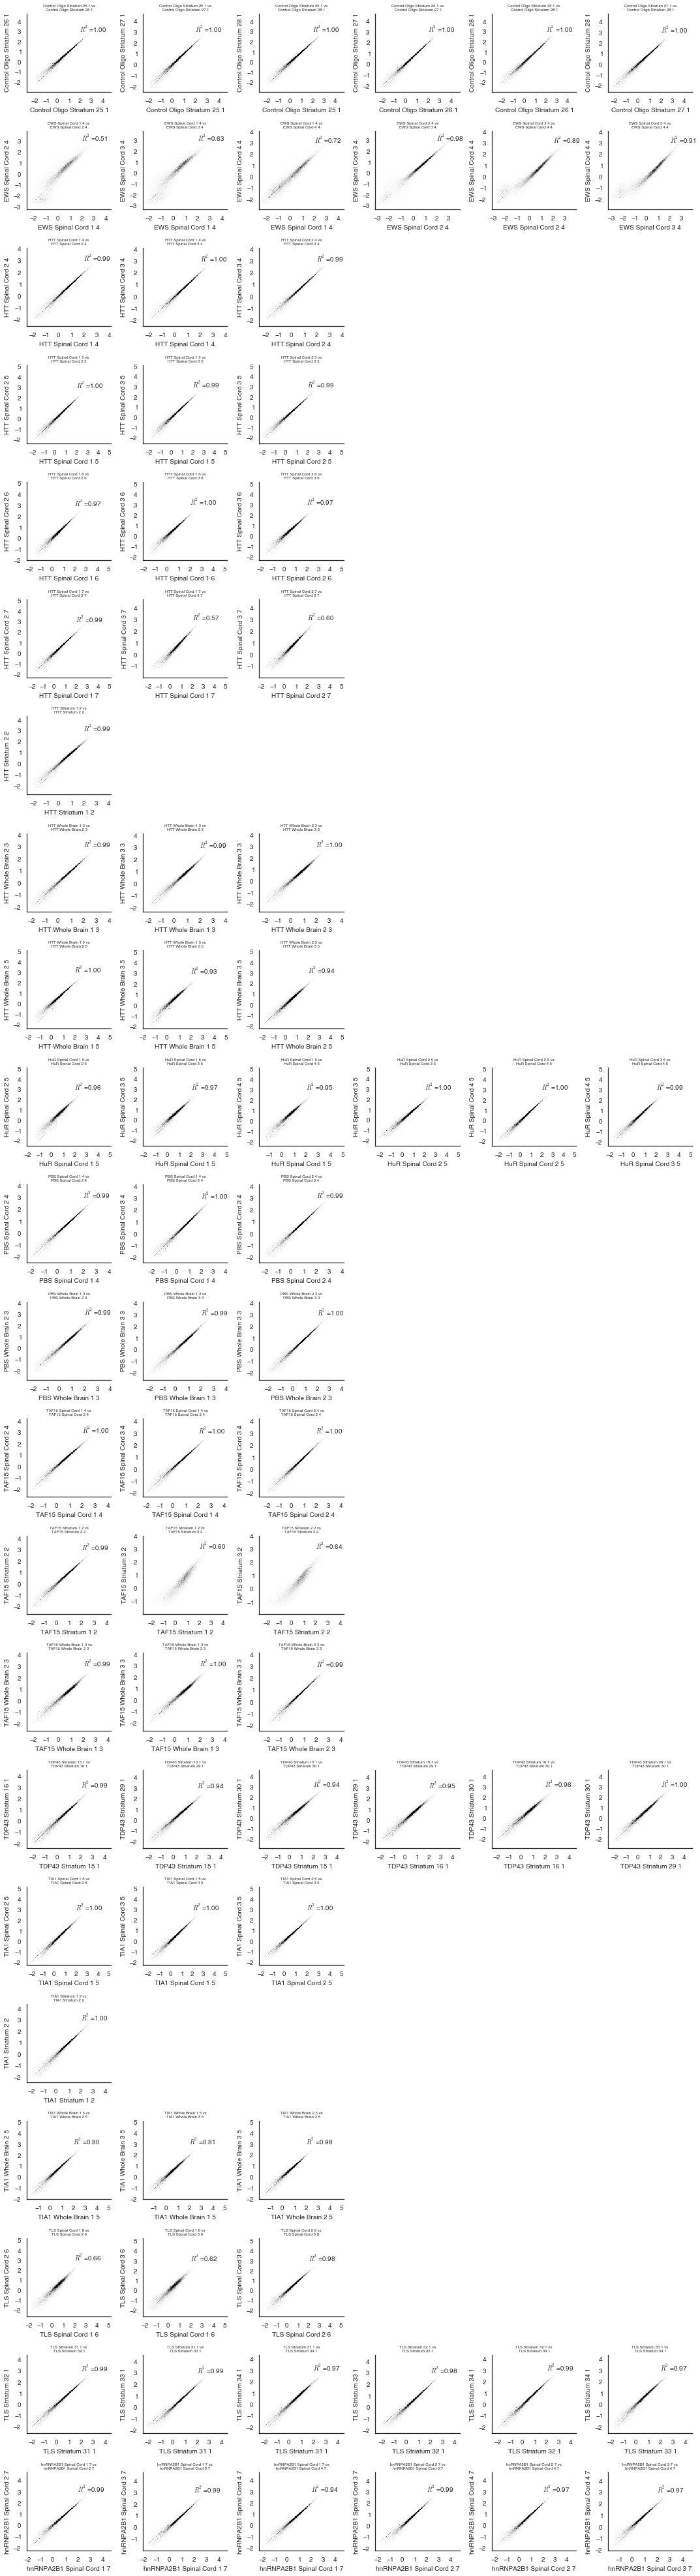

In [8]:
max_combinations = np.max(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group")).count().values)
num_rows = len(list(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = rpkm.ix[name1]
            series2 = rpkm.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[:-1]))
            name2 = " ".join(map(str, name2[:-1]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

Figure Legend: Correlation between all technical replicates for all knockdown and HTT Control conditions for, TAF15, FUS/TLS, EWS, TDP43, hnRNPa2B1 in different tissue types, Spinal Cord, Whole Brain and Straitum

#Only TAF15, FUS/TLS and TDP-43 for figure purpopses

14 6


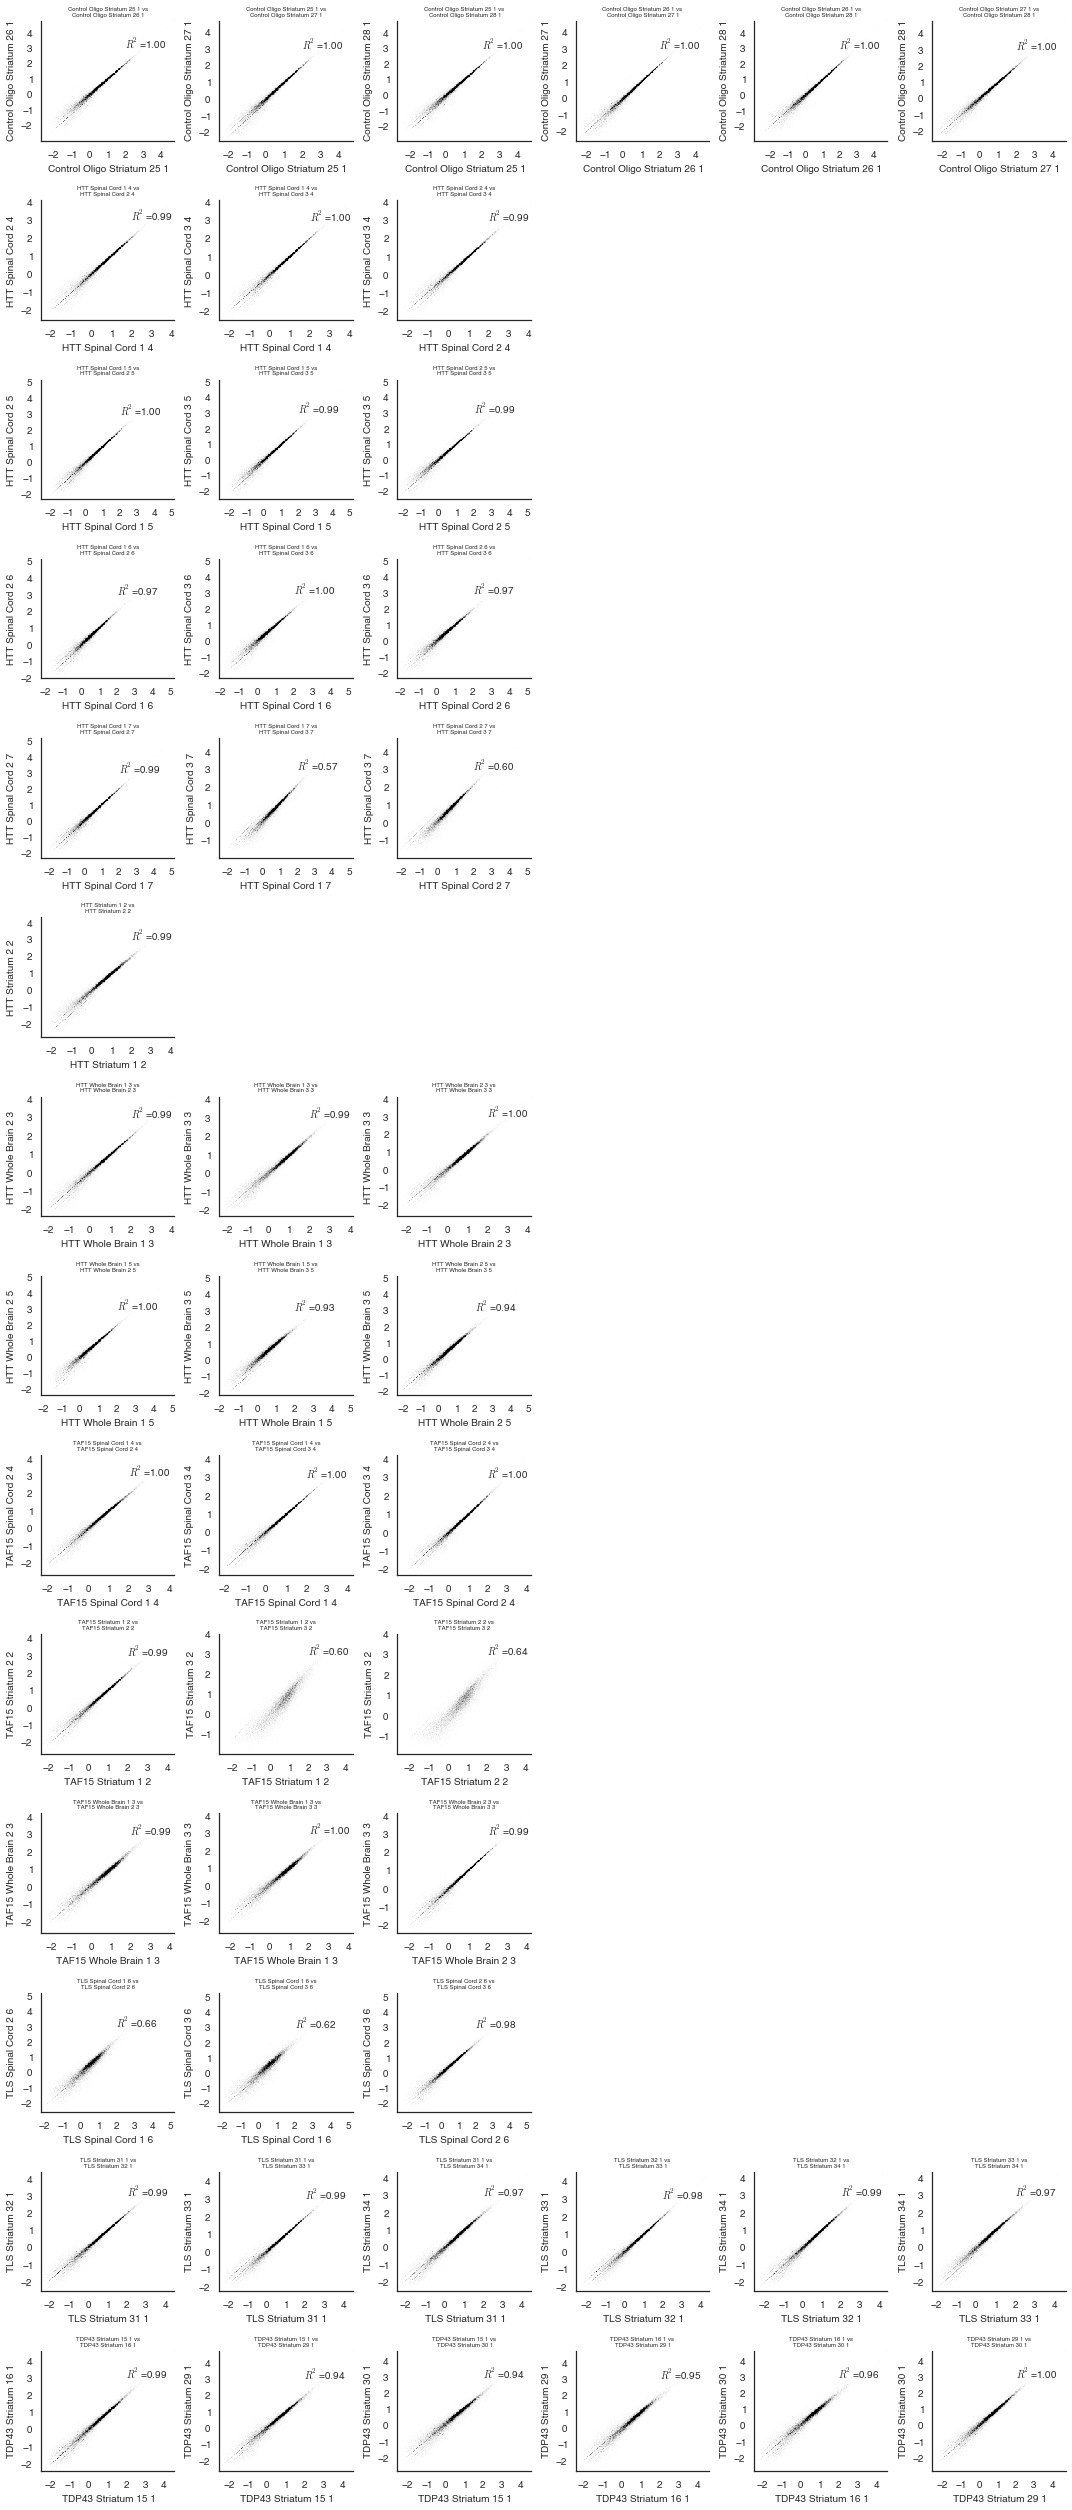

In [9]:
filtered_rpkm = rpkm.ix[['Control Oligo', 'HTT', 'TAF15', 'TLS', 'TDP43']]

max_combinations = np.max(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group")).count().values)
num_rows = len(list(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting_filtered.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = filtered_rpkm.ix[name1]
            series2 = filtered_rpkm.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[:-1]))
            name2 = " ".join(map(str, name2[:-1]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

#Results from Replicate Analysis
1. TAF 15 Straitum Rep 3 is no good, need to drop
2. TIA1 Whole Brain Rep 1 is also not great, should drop
4. No need to use PBS controls, drop them when looking at differental expression
3. All other datasets look good

In [10]:
flotilla_rpkm = flotilla_rpkm.drop("TAF15_ASO_3")
flotilla_rpkm = flotilla_rpkm.drop("TIA1_Br_1")

In [11]:
#Executing
rpkm = rpkm.drop("PBS", level=0)
rpkm = rpkm.drop("TAF15_ASO_3", level="exp")
rpkm = rpkm.drop("TIA1_Br_1", level="exp")

flotilla_rpkm

all_counts = all_counts.drop("TAF15_ASO_3", axis=1)
all_counts = all_counts.drop("TIA1_Br_1", axis=1)

#Output Data for DeSeq

In [12]:
result = {}
for item in rpkm.index: 
    result[item[-1]] = {key: value for value, key in zip(item, rpkm.index.names)}
sampleInfo = pd.DataFrame(result).T 
sampleInfo.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/sampleInfo.csv")

all_counts.T.ix[sampleInfo.index].T.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/important_counts.csv")

#Knockdown Analysis

In [13]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [14]:
feature_frame = pd.DataFrame({"gene_type": gene_id_to_type, "gene_name": gene_id_to_name})

In [15]:
knockdowns = pd.concat({os.path.basename(rbp).split(".")[0]: pd.read_csv(rbp, index_col=0) for rbp in glob.glob("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/deseq/*")})
knockdowns['gene_names'] = [gene_id_to_name[gene_id] for gene_id in knockdowns.index.get_level_values(level=1)]

results = []
for item in knockdowns.index:
    results.append(item[0].split("_") + [item[1]])
knockdowns.index = pd.MultiIndex.from_tuples(results, names=["rbp", 'cell_type', "geneid"])
knockdowns = knockdowns.sortlevel()
knockdowns = knockdowns.drop([" ", "Unnamed: 7"], axis=1)

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


#Knockdown QC

#MA Plots

In [16]:
def ma_plot(df, ax, sig=.05):
    not_sig = df[df.padj > sig]
    sig = df[df.padj <= sig]
    
    ax.scatter(not_sig.baseMean, not_sig.log2FoldChange, c='g', alpha=.5)
    ax.scatter(sig.baseMean, sig.log2FoldChange, c='b', alpha=.5)
 
    ax.set_xlabel("Base Mean")
    ax.set_ylabel("Log 2 Fold Change")
    ax.set_xscale("log")
    return ax

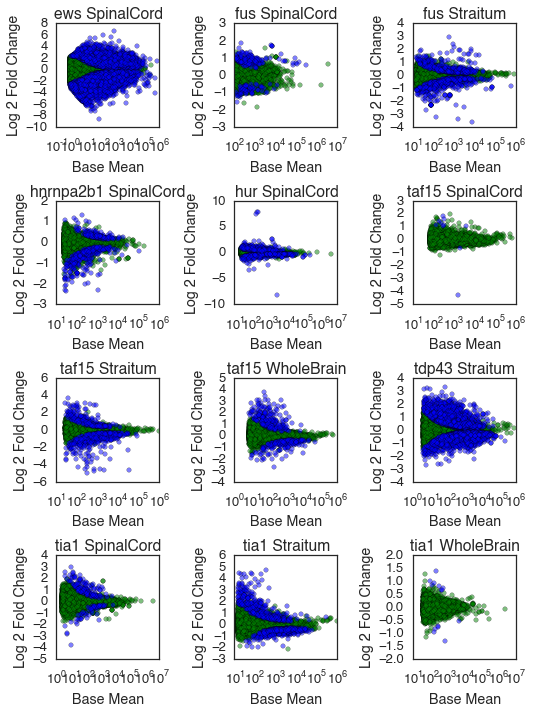

In [17]:
num_rows = 4
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "ma_plots.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    for x, (group, df) in enumerate(knockdowns.groupby(level=['rbp', 'cell_type'])):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        ax = ma_plot(df, ax)
        ax.set_title(" ".join(group))

#Validation Knockdown was Correct for each Gene

In [18]:
knockdowns[knockdowns.gene_names.isin(["Taf15", "Tardbp", "Fus", "Tia1", "Ewsr1"])]

baseMean     lfcSE  \
rbp       cell_type  geneid                                         
ews       SpinalCord ENSMUSG00000009079.10  4167.383868  0.086767   
                     ENSMUSG00000020680.8   1527.859102  0.240035   
                     ENSMUSG00000030795.12  7572.678666  0.129553   
                     ENSMUSG00000041459.8   3121.601627  0.218291   
                     ENSMUSG00000071337.4   2443.509463  0.148529   
fus       SpinalCord ENSMUSG00000009079.10  1742.584418  0.123573   
                     ENSMUSG00000020680.8    497.379332  0.527048   
                     ENSMUSG00000030795.12  1234.298943  0.608721   
                     ENSMUSG00000041459.8    833.613142  0.269400   
                     ENSMUSG00000071337.4    884.380268  0.162327   
          Straitum   ENSMUSG00000009079.10  5749.229025  0.070741   
                     ENSMUSG00000020680.8   2832.591331  0.131012   
                     ENSMUSG00000030795.12  7359.659247  0.159864   
                     ENSMUSG00000041459.8   3738.531064  0.130364   
                     ENSMUSG00000071337.4   3231.909073  0.075007   
hnrnpa2b1 SpinalCord ENSMUSG00000009079.10  1483.523426  0.057694   
                     ENSMUSG00000020680.8    206.625550  0.140048   
                     ENSMUSG00000030795.12   521.706096  0.337840   
                     ENSMUSG00000041459.8   1260.491969  0.061349   
                     ENSMUSG00000071337.4    961.514920  0.070104   
hur       SpinalCord ENSMUSG00000009079.10  1275.493508  0.098908   
                     ENSMUSG00000020680.8    132.316613  0.218126   
                     ENSMUSG00000030795.12   401.075066  0.383957   
                     ENSMUSG00000041459.8    973.563215  0.074313   
                     ENSMUSG00000071337.4    778.450997  0.072909   
taf15     SpinalCord ENSMUSG00000009079.10  4167.383868  0.093452   
                     ENSMUSG00000020680.8   1527.859102  0.276742   
                     ENSMUSG00000030795.12  7572.678666  0.138762   
                     ENSMUSG00000041459.8   3121.601627  0.233235   
                     ENSMUSG00000071337.4   2443.509463  0.159083   
          Straitum   ENSMUSG00000009079.10  4859.038518  0.116287   
                     ENSMUSG00000020680.8   3929.657805  0.787980   
                     ENSMUSG00000030795.12  6140.822035  0.112778   
                     ENSMUSG00000041459.8   3788.884292  0.118443   
                     ENSMUSG00000071337.4   2189.784246  0.430317   
          WholeBrain ENSMUSG00000009079.10  3636.327233  0.126593   
                     ENSMUSG00000020680.8    573.845911  0.134759   
                     ENSMUSG00000030795.12  4768.245366  0.145746   
                     ENSMUSG00000041459.8   3260.572694  0.102925   
                     ENSMUSG00000071337.4   2872.777537  0.143794   
tdp43     Straitum   ENSMUSG00000009079.10  5749.229025  0.070676   
                     ENSMUSG00000020680.8   2832.591331  0.131247   
                     ENSMUSG00000030795.12  7359.659247  0.158212   
                     ENSMUSG00000041459.8   3738.531064  0.131540   
                     ENSMUSG00000071337.4   3231.909073  0.074754   
tia1      SpinalCord ENSMUSG00000009079.10  1275.493508  0.105800   
                     ENSMUSG00000020680.8    132.316613  0.234562   
                     ENSMUSG00000030795.12   401.075066  0.404738   
                     ENSMUSG00000041459.8    973.563215  0.079040   
                     ENSMUSG00000071337.4    778.450997  0.085970   
          Straitum   ENSMUSG00000009079.10  4859.038518  0.116336   
                     ENSMUSG00000020680.8   3929.657805  0.787941   
                     ENSMUSG00000030795.12  6140.822035  0.112916   
                     ENSMUSG00000041459.8   3788.884292  0.118577   
                     ENSMUSG00000071337.4   2189.784246  0.431382   
          WholeBrain ENSMUSG00000009079.10   873.107467  0.147984   
                     ENSMUSG00000020680.8    

Looks like its all good, moving on to analysis

#FUS, TAF15 and TDP43 differental regulation

In [19]:
foo = knockdowns.ix[['fus', 'taf15', 'tdp43']][knockdowns.gene_names.isin(["Taf15", "Tardbp", "Fus"])]
foo[foo.padj < .05]

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


baseMean     lfcSE  log2FoldChange  \
rbp   cell_type  geneid                                                         
fus   Straitum   ENSMUSG00000020680.8   2832.591331  0.131012        0.649105   
                 ENSMUSG00000030795.12  7359.659247  0.159864       -3.587681   
taf15 SpinalCord ENSMUSG00000020680.8   1527.859102  0.276742       -4.232421   
      Straitum   ENSMUSG00000020680.8   3929.657805  0.787980       -3.385239   
      WholeBrain ENSMUSG00000020680.8    573.845911  0.134759       -2.053679   
tdp43 Straitum   ENSMUSG00000030795.12  7359.659247  0.158212       -0.544761   
                 ENSMUSG00000041459.8   3738.531064  0.131540       -2.266671   

                                                 padj         pvalue  \
rbp   cell_type  geneid                                                
fus   Straitum   ENSMUSG00000020680.8    8.710000e-05   7.250000e-07   
                 ENSMUSG00000030795.12  1.450000e-107  1.530000e-111   
taf15 SpinalCord ENSMUSG00000020680.8    1.259754e-48   8.420254e-53   
      Straitum   ENSMUSG00000020680.8    9.920213e-04   1.738292e-05   
      WholeBrain ENSMUSG00000020680.8    3.732917e-48   1.929355e-52   
tdp43 Straitum   ENSMUSG00000030795.12   4.518967e-03   5.748070e-04   
                 ENSMUSG00000041459.8    3.430000e-62   1.530000e-66   

                                             stat gene_names  
rbp   cell_type  geneid                                       
fus   Straitum   ENSMUSG00000020680.8    4.954540      Taf15  
                 ENSMUSG00000030795.12 -22.442092        Fus  
taf15 SpinalCord ENSMUSG00000020680.8  -15.293718      Taf15  
      Straitum   ENSMUSG00000020680.8   -4.296100      Taf15  
      WholeBrain ENSMUSG00000020680.8  -15.239638      Taf15  
tdp43 Straitum   ENSMUSG00000030795.12  -3.443231        Fus  
                 ENSMUSG00000041459.8  -17.231857     Tardbp

#PCA

In [20]:
flotilla_metadata['phenotype'] = [cell_type + " " + rbp for cell_type, rbp in zip(flotilla_metadata['Cell Type'], flotilla_metadata['rbp'])]

In [21]:
study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       flotilla_metadata,
                       version='0.1.0',
                       expression_data = flotilla_rpkm,
                       expression_thresh = 1,
                       species="mm9",
#                        expression_feature_rename_col = "gene_name",
#                        expression_feature_data = feature_frame 
)
study.expression.feature_data = feature_frame
study.expression.feature_rename_col = "gene_name"

2015-07-22 16:42:02	Initializing Study
2015-07-22 16:42:02	Initializing Predictor configuration manager for Study
2015-07-22 16:42:02	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-07-22 16:42:02	Added ExtraTreesClassifier to default predictors
2015-07-22 16:42:02	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-07-22 16:42:02	Added ExtraTreesRegressor to default predictors
2015-07-22 16:42:02	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-07-22 16:42:02	Added GradientBoostingClassifier to default predictors
2015-07-22 16:42:02	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2015-07-22 16:42:02	Added GradientBoostingRegressor to default predictors
2015-07-22 16:42:02	Loading metadata
2015-07-22 16:42:02	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm9 data 

2015-07-22 16:42:03	Loading expression data
2015-07-22 16:42:03	Initializing expression
2015-07-22 16:42:03	Done initializing expression
2015-07-22 16:42:03	Successfully initialized a Study object!


/nas3/gpratt/anaconda/lib/python2.7/site-packages/flotilla-0.2.5.dev0-py2.7.egg/flotilla/data_model/metadata.py:186: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0


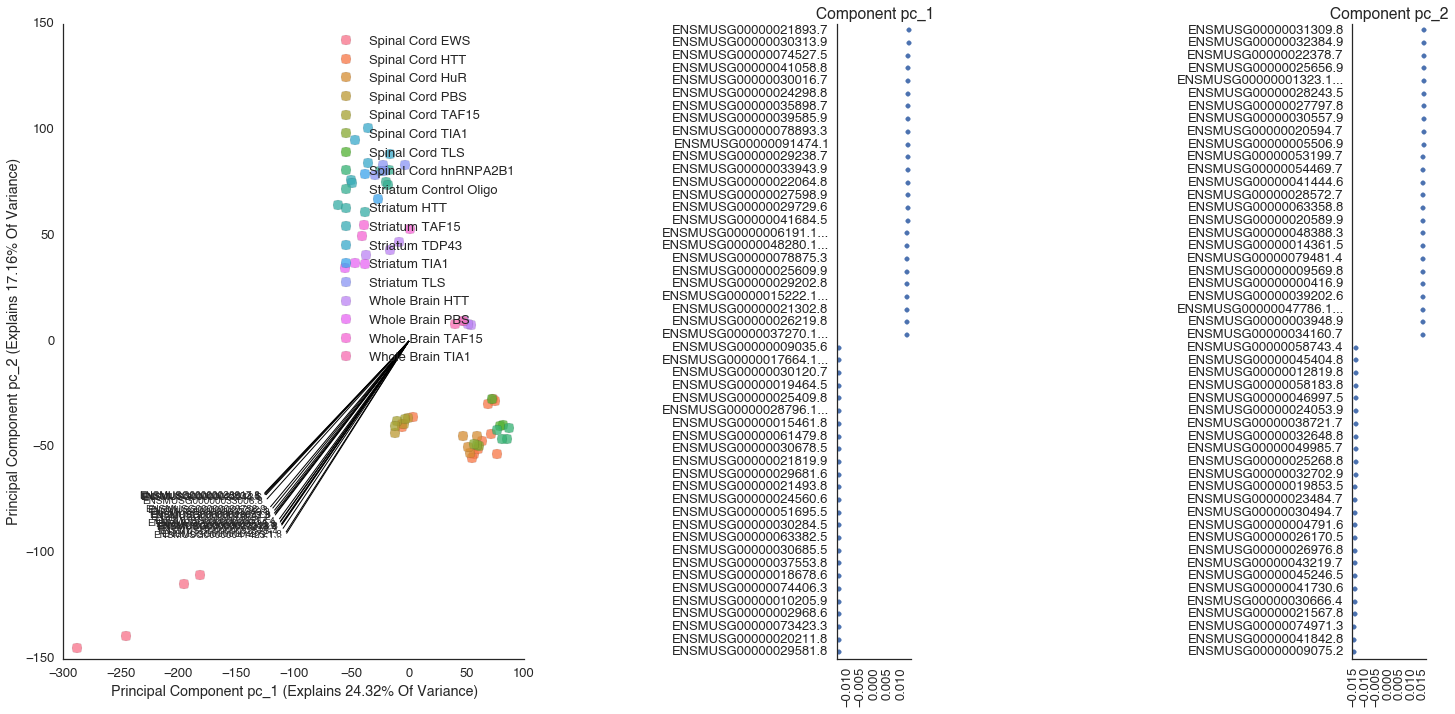

In [22]:
study.plot_pca(feature_subset="gene_type: protein_coding")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes

In [23]:
#study.metadata.phenotype_to_color = {key: value for key, value in zip(study.metadata.phenotype_to_color, result)}
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="Cell Type: Striatum")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in striatum

In [24]:
#study.metadata.phenotype_to_color = {key: value for key, value in zip(study.metadata.phenotype_to_color, result)}
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 1")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 1 (subset of experiments done at the same time with same control)

In [25]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 2")

In [26]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 3")

In [27]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 4")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 4 (subset of experiments done at the same time with same control)

In [28]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 5")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 5 (subset of experiments done at the same time with same control)

In [29]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 6")

In [30]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 7")

In [31]:
#study.interactive_pca()

#Knockdown Analysis

In [284]:
significant_knockdowns = knockdowns[(knockdowns.padj <= .05) & (abs(knockdowns.log2FoldChange) > 1)]
unchanging_knockdowns = knockdowns[~((knockdowns.padj <= .05) & (abs(knockdowns.log2FoldChange) > 1))]

signifcant_upregulated = significant_knockdowns[significant_knockdowns.log2FoldChange > 0]
signifcant_downregulated = significant_knockdowns[significant_knockdowns.log2FoldChange < 0]
unregulated_knockdowns = knockdowns[(knockdowns.padj >= .05) & (abs(knockdowns.log2FoldChange) > 1)]


In [33]:
significant_knockdowns.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    11152
fus        SpinalCord       57
           Straitum        173
hnrnpa2b1  SpinalCord       79
hur        SpinalCord       98
taf15      SpinalCord        9
           Straitum        266
           WholeBrain      190
tdp43      Straitum        980
tia1       SpinalCord      101
           Straitum        271
           WholeBrain        3
Name: padj, dtype: int64

In [34]:
signifcant_downregulated.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    5987
fus        SpinalCord      15
           Straitum       113
hnrnpa2b1  SpinalCord      75
hur        SpinalCord      30
taf15      SpinalCord       1
           Straitum       171
           WholeBrain      45
tdp43      Straitum       273
tia1       SpinalCord      24
           Straitum        31
           WholeBrain       1
Name: padj, dtype: int64

In [35]:
signifcant_upregulated.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    5165
fus        SpinalCord      42
           Straitum        60
hnrnpa2b1  SpinalCord       4
hur        SpinalCord      68
taf15      SpinalCord       8
           Straitum        95
           WholeBrain     145
tdp43      Straitum       707
tia1       SpinalCord      77
           Straitum       240
           WholeBrain       2
Name: padj, dtype: int64

In [36]:
expressed_only_in_spial_cord = set(significant_knockdowns.ix['taf15', 'SpinalCord'].index) - set(significant_knockdowns.ix['taf15', 'WholeBrain'].index)

In [37]:
significant_knockdowns.ix['taf15', 'SpinalCord'].ix[expressed_only_in_spial_cord]

baseMean     lfcSE  log2FoldChange      padj  \
geneid                                                                  
ENSMUSG00000044786.5   298.697340  0.251422        1.049772  0.046426   
ENSMUSG00000069516.6   242.168592  0.244628        1.266296  0.000677   
ENSMUSG00000036887.5  3756.826409  0.254368        1.088235  0.040271   
ENSMUSG00000090698.1   194.326860  0.340532        1.418574  0.046426   
ENSMUSG00000028195.3   284.918101  0.269092        1.806805  0.000000   
ENSMUSG00000030124.2   351.122408  0.310557        1.618784  0.000677   
ENSMUSG00000061132.7   138.485230  0.232448        1.097464  0.005843   
ENSMUSG00000020423.6   337.415832  0.265627        1.107387  0.046426   

                            pvalue      stat gene_names  
geneid                                                   
ENSMUSG00000044786.5  2.975499e-05  4.175333      Zfp36  
ENSMUSG00000069516.6  2.262007e-07  5.176406       Lyz2  
ENSMUSG00000036887.5  1.884226e-05  4.278186       C1qa  
ENSMUSG00000090698.1  3.103127e-05  4.165763     Apold1  
ENSMUSG00000028195.3  1.887608e-11  6.714462      Cyr61  
ENSMUSG00000030124.2  1.862980e-07  5.212514       Lag3  
ENSMUSG00000061132.7  2.343154e-06  4.721323       Blnk  
ENSMUSG00000020423.6  3.060054e-05  4.168951       Btg2

In [38]:
HTML(signifcant_downregulated.ix['taf15'].to_html())

In [39]:
HTML(signifcant_upregulated.ix['taf15'].to_html())

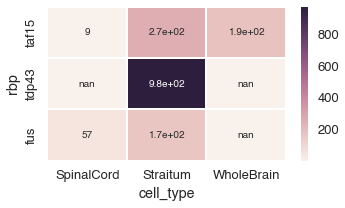

In [40]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(significant_knockdowns.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), 
                ax=ax, annot=True)

Figure Legend: Total Number of Significantly Changing Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

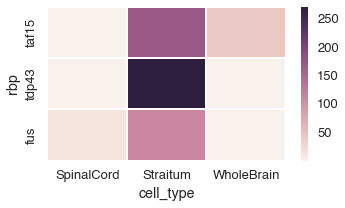

In [41]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(signifcant_downregulated.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), ax=ax)

Figure Legend: Total Number of Significantly downregulated Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

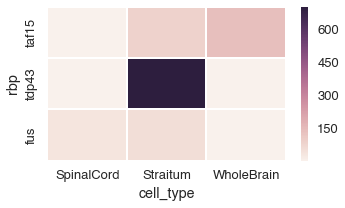

In [42]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(signifcant_upregulated.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), ax=ax)

Figure Legend: Total Number of Significantly upregulated Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

In [43]:
rbp_colors = {"spinalcord": 'r',
              'straitum': 'g',
              'wholebrain': 'b',
              'fus_taf15': 'c',
              'taf15_tdp43': 'c',
              "fus": 'r',
              'taf15': 'g',
              'tdp43': 'b',}

rbp_names = {"spinalcord": 'Spinal Cord',
              'straitum': 'Straitum',
              'wholebrain': 'Whole Brain',
              'fus_taf15': 'FUS TAF15',
              'taf15_tdp43': 'TAF15 TDP43',
              "fus": 'FUS',
              'taf15': 'TAF15',
              'tdp43': 'TDP43',}

#TAF15 Tissue Specific analysis

Count Number of overlapping Changes for text
----

In [44]:
print "overlap down", len(signifcant_downregulated.ix['taf15', 'SpinalCord'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'WholeBrain'].index)
print "all down", len(signifcant_downregulated.ix['taf15', 'SpinalCord'].index | signifcant_downregulated.ix['taf15', 'Straitum'].index | signifcant_downregulated.ix['taf15', 'WholeBrain'].index)

print "overlap up", len(signifcant_upregulated.ix['taf15', 'SpinalCord'].index & signifcant_upregulated.ix['taf15', 'Straitum'].index & signifcant_upregulated.ix['taf15', 'WholeBrain'].index)
print "all up", len(signifcant_upregulated.ix['taf15', 'SpinalCord'].index | signifcant_upregulated.ix['taf15', 'Straitum'].index | signifcant_upregulated.ix['taf15', 'WholeBrain'].index)

print "total differentaly expressed genes", 206 + 182

overlap down 1
all down 206
overlap up 0
all up 182
total differentaly expressed genes 388


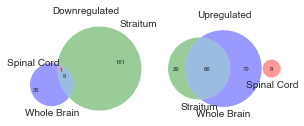

In [271]:
with dataviz.Figure(os.path.join(img_dir, "taf15_tissue_specific_changes.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['taf15', 'SpinalCord'].index,
                  signifcant_downregulated.ix['taf15', 'Straitum'].index,
                  signifcant_downregulated.ix['taf15', 'WholeBrain'].index,],
            set_labels=("Spinal Cord", "Straitum", "Whole Brain"), 
            set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['taf15', 'SpinalCord'].index,
                  signifcant_upregulated.ix['taf15', 'Straitum'].index,
                  signifcant_upregulated.ix['taf15', 'WholeBrain'].index,],
            set_labels=("Spinal Cord", "Straitum", "Whole Brain"),
            set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Figure Legend: Co-Down and Up Regulated Genes for TAF15 in Spinal Cord, Straitum and Whole Brain

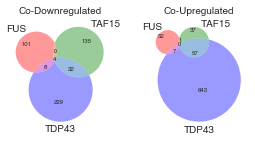

In [46]:
with dataviz.Figure(os.path.join(img_dir, "fet_family_straitum_overlap.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['fus', 'Straitum'].index,
    signifcant_downregulated.ix['taf15', 'Straitum'].index,
    signifcant_downregulated.ix['tdp43', 'Straitum'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)

    ax.set_title("Co-Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['fus', 'Straitum'].index,
    signifcant_upregulated.ix['taf15', 'Straitum'].index,
    signifcant_upregulated.ix['tdp43', 'Straitum'].index,],
            set_labels=("FUS", "TAF15", "TDP43"),
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)

    ax.set_title("Co-Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Figure Legend: Co-down and up regulated Genes in Straitum comparing FUS, TAF15 and TDP43

In [311]:
[gene_id_to_name[gene_id] for gene_id in signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index]

['Park2', 'Kcnip4', 'Csmd1', 'Nkain2']

In [47]:
HTML(signifcant_downregulated.ix['fus'].to_html())

In [48]:
signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index

Index([u'ENSMUSG00000023826.7', u'ENSMUSG00000029088.8', u'ENSMUSG00000060924.7', u'ENSMUSG00000075259.3'], dtype='object')

In [49]:
signifcant_upregulated.ix['fus', 'Straitum'].index & signifcant_upregulated.ix['taf15', 'Straitum'].index 

Index([u'ENSMUSG00000037833.7'], dtype='object')

In [50]:
mm9go = GO.mm9GO()

In [51]:
mapper = {
('ews', 'SpinalCord'): ("HTT", "Spinal Cord", 4),
('fus', 'SpinalCord'): ("HTT", "Spinal Cord", 6),
('fus', 'Straitum'): ("Control Oligo", "Striatum", 1),
('hnrnpa2b1', 'SpinalCord'): ("HTT", "Spinal Cord", 7),
('hur', 'SpinalCord'): ("HTT", "Spinal Cord", 5),
('taf15', 'SpinalCord'): ("HTT", "Spinal Cord", 4),
('taf15', 'Straitum'): ("HTT", "Striatum", 2),
('taf15', 'WholeBrain'): ("HTT", "Whole Brain", 3),
('tdp43', 'Straitum'): ("Control Oligo", "Striatum", 1),
('tia1', 'SpinalCord'): ("HTT", "Spinal Cord", 5),
('tia1', 'Straitum'): ("HTT", "Striatum", 2),
('tia1', 'WholeBrain'): ("HTT", "Whole Brain", 5),
}

In [57]:
downregulated_go = {}
for name, df in signifcant_downregulated.groupby(level=["rbp", "cell_type"]):
    mapping = mapper[name]
    indexer = mapping[:-1]
    analysis_group = mapping[-1]
    
    control_rpkms = rpkm.xs(analysis_group, level="analysis_group").ix[indexer]
    expressed_genes = gencode_to_ensembl(control_rpkms[control_rpkms > 1].dropna(axis=1).columns)
    downregulated_go[name] = mm9go.enrichment(gencode_to_ensembl(df.index.get_level_values("geneid")),
                                              background=expressed_genes)
downregulated_go = pd.concat(downregulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()

upregulated_go = {}
for name, df in signifcant_upregulated.groupby(level=["rbp", "cell_type"]):
    
    mapping = mapper[name]
    indexer = mapping[:-1]
    analysis_group = mapping[-1]
    
    control_rpkms = rpkm.xs(analysis_group, level="analysis_group").ix[indexer]
    expressed_genes = gencode_to_ensembl(control_rpkms[control_rpkms > 1].dropna(axis=1).columns)
    upregulated_go[name] = mm9go.enrichment(gencode_to_ensembl(df.index.get_level_values("geneid")),
                                            background=expressed_genes)
upregulated_go = pd.concat(upregulated_go, names=["rbp", 'cell_type', "GO Term ID"])
all_go = pd.concat({"upregulated": upregulated_go, "downregulated": downregulated_go}).dropna()

In [58]:
all_go.xs("Straitum", level="cell_type")

GO Term Description  \
              rbp   GO Term ID                                                      
downregulated fus   GO:0003674                                 molecular_function   
                    GO:0003677                                        DNA binding   
                    GO:0003700  sequence-specific DNA binding transcription fa...   
                    GO:0005515                                    protein binding   
                    GO:0005575                                 cellular_component   
                    GO:0005634                                            nucleus   
                    GO:0005737                                          cytoplasm   
                    GO:0005886                                    plasma membrane   
                    GO:0008150                                 biological_process   
                    GO:0008270                                   zinc ion binding   
                    GO:0016021                               integral to membrane   
              taf15 GO:0005887                        integral to plasma membrane   
                    GO:0005615                                extracellular space   
                    GO:0016021                               integral to membrane   
                    GO:0005261                            cation channel activity   
                    GO:0005179                                   hormone activity   
                    GO:0005604                                  basement membrane   
                    GO:0007155                                      cell adhesion   
                    GO:0005198                       structural molecule activity   
                    GO:0015293                                 symporter activity   
                    GO:0030173                         integral to Golgi membrane   
                    GO:0005578                 proteinaceous extracellular matrix   
                    GO:0031225                               anchored to membrane   
                    GO:0016020                                           membrane   
                    GO:0005215                               transporter activity   
                    GO:0005886                                    plasma membrane   
                    GO:0009986                                       cell surface   
                    GO:0031012                               extracellular matrix   
                    GO:0042383                                         sarcolemma   
                    GO:0016324                             apical plasma membrane   
...                                                                           ...   
upregulated   tia1  GO:0008270                                   zinc ion binding   
                    GO:0008150                                 biological_process   
                    GO:0042802                          identical protein binding   
                    GO:0042803                  protein homodimerization activity   
                    GO:0007283                                    spermatogenesis   
                    GO:0045944  positive regulation of transcription from RNA ...   
                    GO:0046872                                  metal ion binding   
                    GO:0003674                                 molecular_function   
                    GO:0006508                                        proteolysis   
                    GO:0003677                                        DNA binding   
                    GO:0003700  sequence-specific DNA binding transcription fa...   
                    GO:0003723                                        RNA binding   
                    GO:0003924                                    GTPase activity   
                    GO:0005509                                calcium ion binding   
                    GO:0005515                                    p

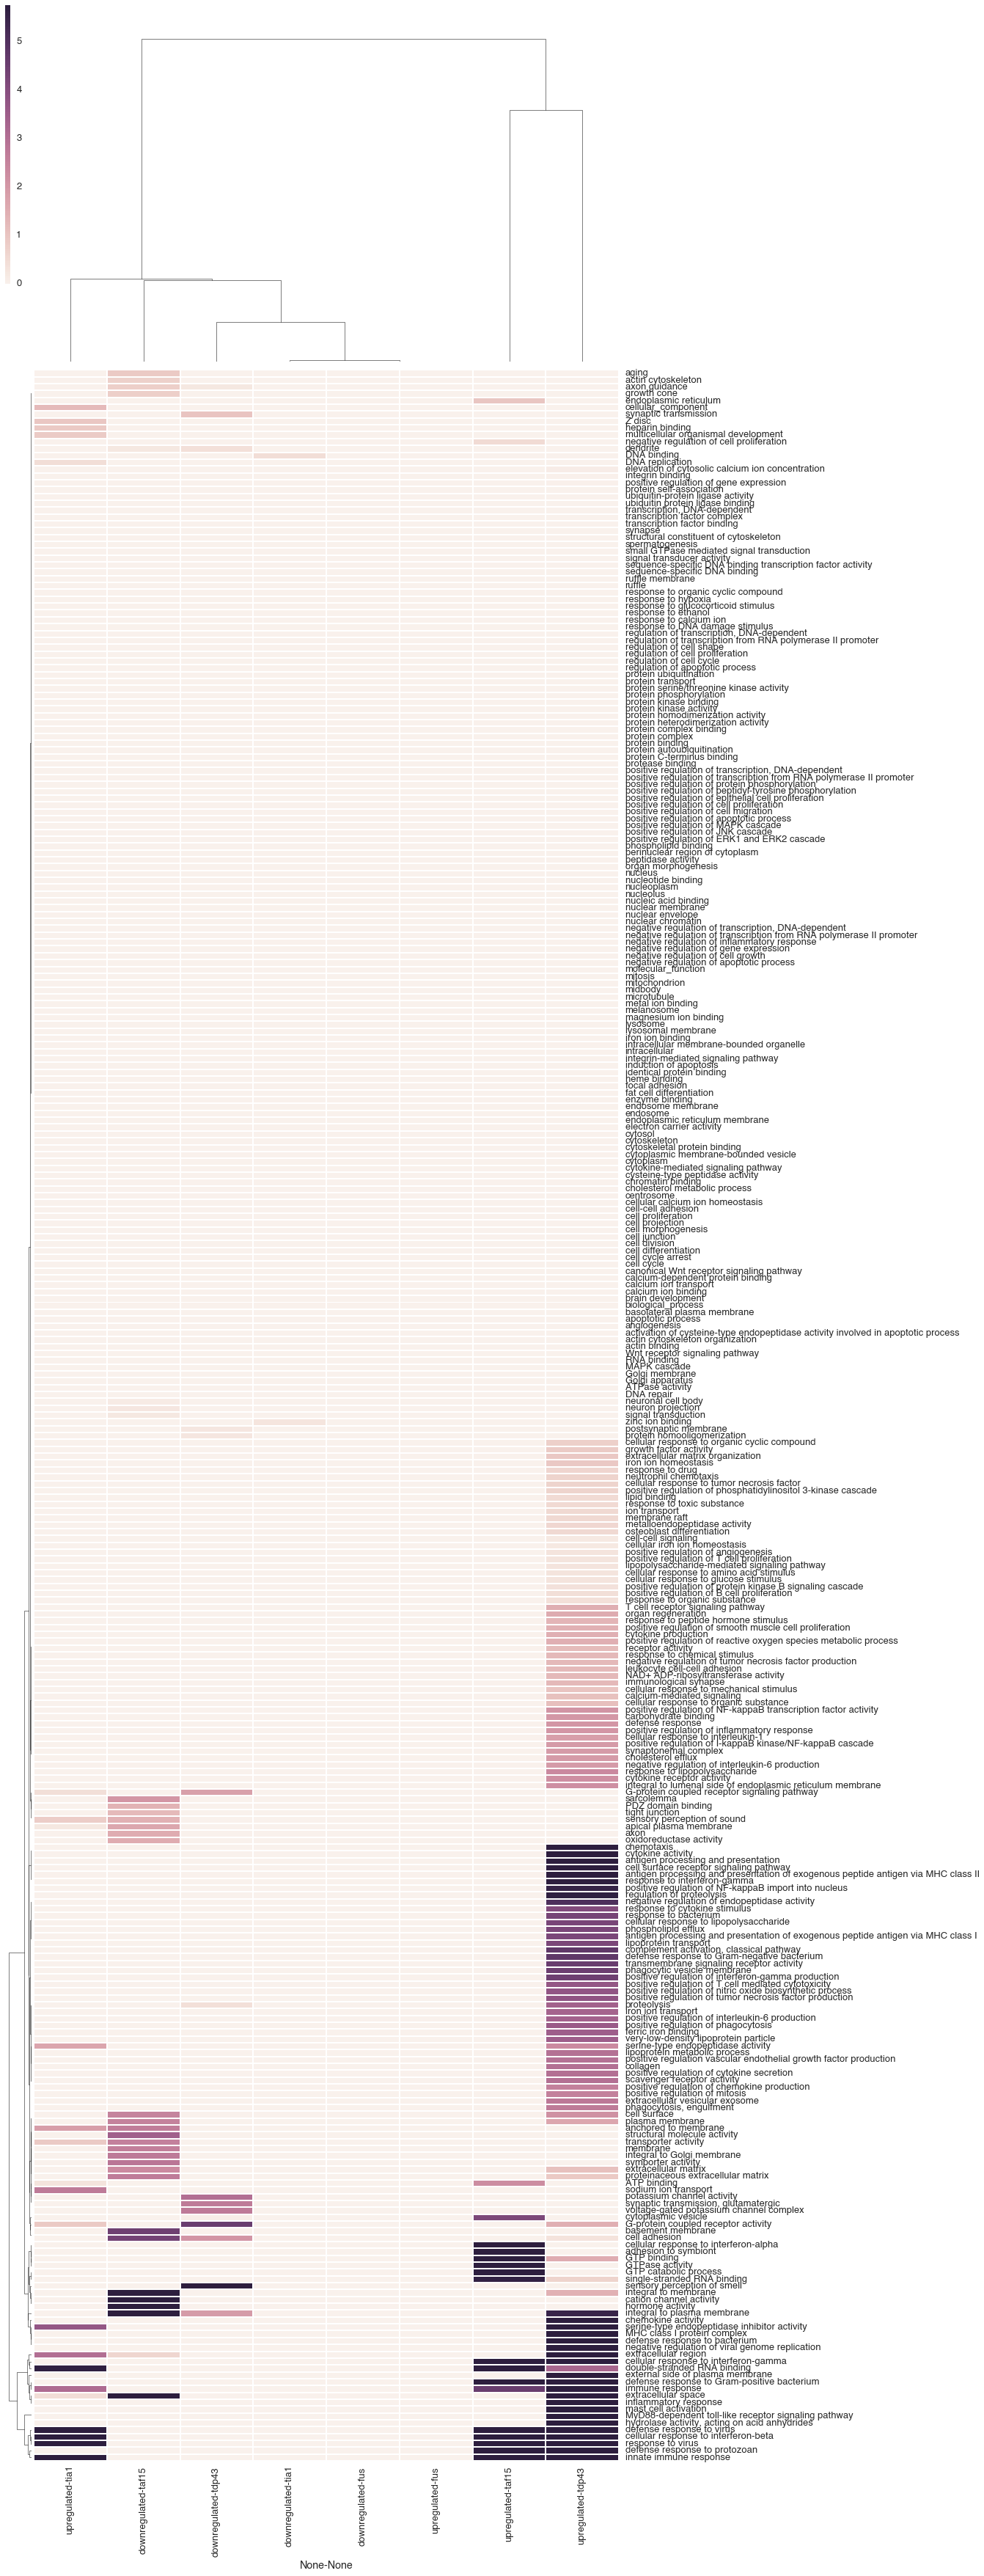

In [62]:
dataviz.plot_go_enrichment(all_go.xs("Straitum", level="cell_type"), figsize=(15,60)) 

Figure Legend: GO Enrichment for up and down regulated genes for all knockdowns in Straitum, TAF15, TIA1, TDP43 and FUS

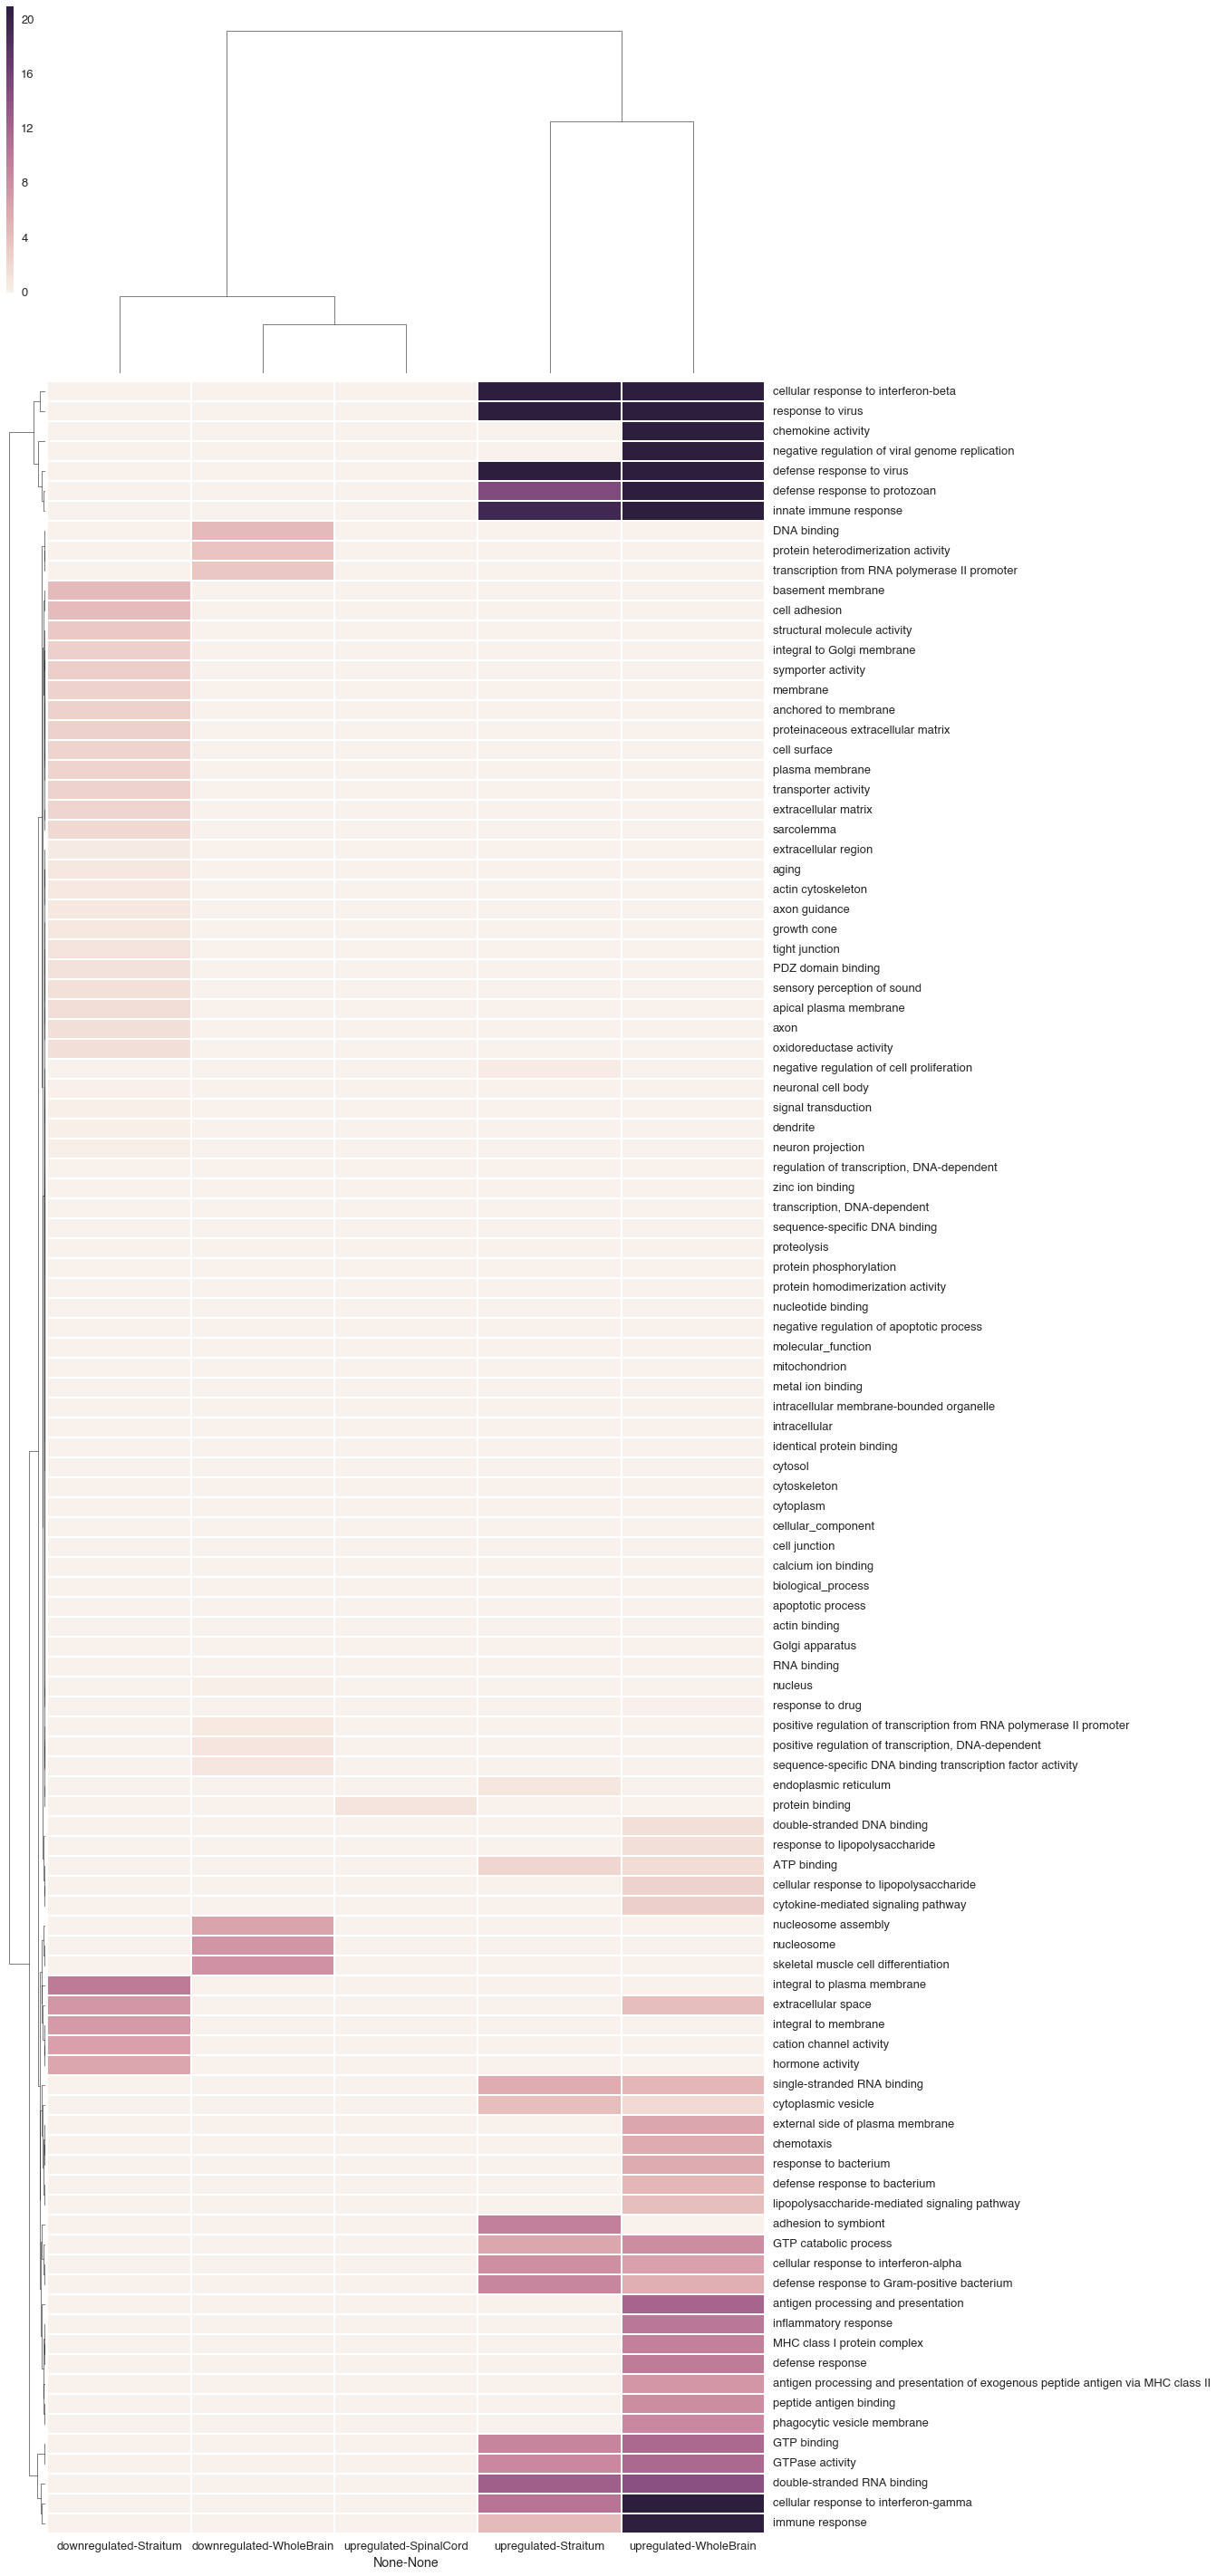

In [63]:
dataviz.plot_go_enrichment(all_go.xs("taf15", level="rbp"), figsize=(15,50)) 

Figure Legend: GO Enrichment for up and down regulated genes for TAF15 in Whole Brain, Spinal Cord and Straitum

#Gene Specific Analysis (ALS Specific)

In [64]:
name_to_gene_id_lower = {key.lower(): value for key, value in name_to_gene_id.items()}
als_specific_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/als_specific_genes/Workbook1.xlsx", "Sheet1")

In [65]:
als_specific_genes = als_specific_genes.applymap(lambda x: x.lower())

In [66]:
als_specifc_gene_list = []
for als_gene in als_specific_genes['Gene symbol']:
    try:
        als_specifc_gene_list.append(name_to_gene_id_lower[als_gene])
    except KeyError:
        print als_gene

als3
als7
arhgef28
c1orf27
c9orf72
cyp2d6
diaph3
naip
rnase2
smn2
syne
znf746


In [67]:
significant_knockdowns[[gene_id in als_specifc_gene_list for gene_id in significant_knockdowns.index.get_level_values(level="geneid")]]

baseMean     lfcSE  \
rbp       cell_type  geneid                                           
ews       SpinalCord ENSMUSG00000000738.11    2153.983247  0.143658   
                     ENSMUSG00000002985.9    79260.729428  0.201184   
                     ENSMUSG00000005089.8    65570.784776  0.254507   
                     ENSMUSG00000006611.8      271.611444  0.157712   
                     ENSMUSG00000018293.3     3719.907775  0.154779   
                     ENSMUSG00000020128.8      725.336175  0.213657   
                     ENSMUSG00000021743.5       11.610163  0.984670   
                     ENSMUSG00000022982.9     6177.465034  0.194923   
                     ENSMUSG00000023064.4     3718.863185  0.138770   
                     ENSMUSG00000023484.7     2532.134468  0.108907   
                     ENSMUSG00000025232.6     1864.017785  0.204597   
                     ENSMUSG00000026235.7     1223.559933  0.140741   
                     ENSMUSG00000026585.7     6787.400181  0.302203   
                     ENSMUSG00000027365.8     1399.410472  0.304754   
                     ENSMUSG00000027447.6    44578.902383  0.126526   
                     ENSMUSG00000027551.8      855.993779  0.186307   
                     ENSMUSG00000028393.4     1021.396935  0.141772   
                     ENSMUSG00000028964.8     4179.301875  0.131121   
                     ENSMUSG00000029759.2       88.049271  0.342659   
                     ENSMUSG00000030092.8      507.025716  0.388518   
                     ENSMUSG00000030271.8      292.020852  0.213282   
                     ENSMUSG00000030905.5       15.243456  0.516311   
                     ENSMUSG00000031865.9    23801.505270  0.131961   
                     ENSMUSG00000031980.9    14633.356610  0.088999   
                     ENSMUSG00000034108.5      762.796302  0.238304   
                     ENSMUSG00000034394.8       42.826975  0.341075   
                     ENSMUSG00000034708.4     3224.291317  0.263199   
                     ENSMUSG00000034810.7      128.397782  0.366219   
                     ENSMUSG00000035960.6      305.646389  0.255773   
                     ENSMUSG00000037236.7     5973.253438  0.367263   
                     ENSMUSG00000039713.10    1446.307188  0.146775   
                     ENSMUSG00000041046.7      134.131272  0.297038   
                     ENSMUSG00000041459.8     3121.601627  0.218291   
                     ENSMUSG00000043535.7     2338.630017  0.178287   
                     ENSMUSG00000046532.7     1399.352987  0.256080   
                     ENSMUSG00000047037.5     1397.216829  0.252208   
                     ENSMUSG00000048251.9      859.750909  0.241306   
                     ENSMUSG00000049422.6     6855.604789  0.264502   
                     ENSMUSG00000053166.7     2481.633895  0.231457   
                     ENSMUSG00000062209.8     1329.850266  0.303838   
                     ENSMUSG00000062960.6      304.779024  0.277740   
                     ENSMUSG00000064293.7      893.512429  0.271526   
                     ENSMUSG00000064345.1   106381.543623  0.692451   
                     ENSMUSG00000073563.2     1115.290946  0.226992   
                     ENSMUSG00000090223.1      482.977010  0.390869   
fus       SpinalCord ENSMUSG00000050148.8      380.234505  0.314391   
          Straitum   ENSMUSG00000030795.12    7359.659247  0.159864   
hnrnpa2b1 SpinalCord ENSMUSG00000004980.9     1131.553236  0.123377   
hur       SpinalCord ENSMUSG00000030795.12     401.075066  0.383957   
taf15     SpinalCord ENSMUSG00000020680.8     1527.859102  0.276742   
          Straitum   ENSMUSG00000020680.8     3929.657805  0.787980   
                     ENSMUSG00000029759.2      173.920344  0.340214   
                     ENSMUSG00000062209.8     1146.305869  0.151054   
          WholeBrain ENSMUSG00000020680.8      573.845911  0.134759   
                     ENSMUSG00000024529.6       58.709373  0.253666   
td

In [68]:
significant_knockdowns

baseMean     lfcSE  log2FoldChange  \
rbp  cell_type  geneid                                                          
ews  SpinalCord ENSMUSG00000000001.4     869.683077  0.264146       -1.286879   
                ENSMUSG00000000037.9      55.732740  0.563567       -1.234795   
                ENSMUSG00000000088.6    3409.852177  0.288460        3.015502   
                ENSMUSG00000000093.6      75.861849  0.540279        1.602079   
                ENSMUSG00000000094.6      13.083276  0.647869        2.199118   
                ENSMUSG00000000120.6     145.988040  0.297900        1.386905   
                ENSMUSG00000000125.5     575.485748  0.167010        1.484557   
                ENSMUSG00000000126.5      65.561238  0.323124        1.128147   
                ENSMUSG00000000127.7     443.092803  0.244693       -1.695222   
                ENSMUSG00000000148.10   1055.573483  0.156881        1.310100   
                ENSMUSG00000000149.5   13669.200774  0.119127        1.307159   
                ENSMUSG00000000154.8      49.596367  0.444588        1.934889   
                ENSMUSG00000000167.8      29.893434  0.493165       -1.366904   
                ENSMUSG00000000182.7      17.525972  0.604394        1.501215   
                ENSMUSG00000000197.6    2188.287563  0.227284       -1.618291   
                ENSMUSG00000000202.3    1163.608007  0.259575        1.605998   
                ENSMUSG00000000214.4     193.068816  0.305061        1.283958   
                ENSMUSG00000000216.7       5.842759  0.956300        2.651499   
                ENSMUSG00000000253.6    2408.022581  0.174222        1.160340   
                ENSMUSG00000000266.5     791.381929  0.267917       -2.019651   
                ENSMUSG00000000275.9     355.521115  0.287024        1.121115   
                ENSMUSG00000000282.6    1814.981767  0.145655        1.610945   
                ENSMUSG00000000290.7     274.939655  0.225847        1.346573   
                ENSMUSG00000000301.9     137.272408  0.255176        1.387869   
                ENSMUSG00000000325.8    2095.105221  0.140944        1.702301   
                ENSMUSG00000000326.6    3365.400445  0.109810        1.740170   
                ENSMUSG00000000339.8     819.984043  0.251059        1.111153   
                ENSMUSG00000000340.6     490.474923  0.278985       -1.547672   
                ENSMUSG00000000355.6     651.086004  0.389776       -1.588565   
                ENSMUSG00000000359.3      19.983103  0.545337        1.440572   
...                                             ...       ...             ...   
tia1 Straitum   ENSMUSG00000087130.1     371.906104  0.282200        1.113068   
                ENSMUSG00000087270.2      87.991009  0.309176        1.020018   
                ENSMUSG00000087373.1      42.737756  0.616865        3.277144   
                ENSMUSG00000087386.1      39.465952  0.456644        1.382354   
                ENSMUSG00000087480.1      21.858724  0.593529        1.985943   
                ENSMUSG00000087483.2      65.791740  0.398439        1.893043   
                ENSMUSG00000089922.1     352.293626  0.313334        1.691587   
                ENSMUSG00000089940.1      77.259393  0.417144        1.482152   
                ENSMUSG00000090210.1     161.880214  0.333291        1.644047   
                ENSMUSG00000090272.1      45.031910  0.437739        2.311972   
                ENSMUSG00000090390.1      15.247794  0.689563        2.368019   
                ENSMUSG00000090673.1     196.872854  0.369866        1.829535   
                ENSMUSG00000090683.1      81.367126  0.321600        1.059464   
                ENSMUSG00000091034.1      22.884263  0.662381        3.533263   
                ENSMUSG00000091137.1      30.466511  0.596466        2.570732   
                ENSMUSG00000091144.1      57.705918  0.387439        1.351999   
                ENSMUSG00000091173.1      15.247794  0.689563        2.368

#Miso Splicing Data

In [71]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/
!scp tscc-login1.sdsc.edu:/home/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv /nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv

miso_diff_merged.csv                          100% 1438MB  29.4MB/s   00:49    


In [72]:
all_splicing_events = pd.read_csv("/nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv", index_col=[0,1,2])

new_index = []
factor_cashe = {}
for rbp, factor, event in all_splicing_events.index:
    if factor not in factor_cashe:
        splice_type = factor.split("_")[-1]

        rbp, control = factor.split("vs")
        control = "_".join(control.split("_")[:-1])
        rbp = biorep_info.ix[rbp]
        control = biorep_info.ix[control]
        rbp_rep = rbp.bio_rep
        rbp_name = rbp.rbp
        cell_type = rbp['Cell Type']
        control_rep = control.bio_rep

        factor_cashe[factor] = [rbp_name, rbp_rep, control_rep, cell_type, splice_type]

    index = copy.copy(factor_cashe[factor])
    index.append(event)

    new_index.append(index)
    
all_splicing_events.index = pd.MultiIndex.from_tuples(new_index, names=['rbp', 'rbp_rep', "control_rep", "cell_type", "splice_type", 'event'])

In [73]:
significant_splicing_events = all_splicing_events[(all_splicing_events.bayes_factor > 3) & (abs(all_splicing_events['diff']) > .25)]
inclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] > 0]
exclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] < 0]

In [74]:
HTML(pd.concat({"all": significant_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep', 'cell_type', 'splice_type']).count()['sample1_posterior_mean'],
            "included": inclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'cell_type', 'splice_type']).count()['sample1_posterior_mean'],
            "excluded": exclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'cell_type', 'splice_type']).count()['sample1_posterior_mean'],}).unstack(level=0).to_html())

In [75]:
inclusion_counts = inclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'cell_type', 'event']).count()
exclusion_counts = exclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'cell_type', 'event']).count()

In [76]:
confident_inclusion_events = []
for group, df in inclusion_counts.groupby(level=['rbp', 'cell_type']):
    rbp, cell_type = group
    rbp_rep_num = len(set(inclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="rbp_rep")))
    control_rep_num = len(set(inclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="control_rep")))
    possible_reps = rbp_rep_num * control_rep_num
    df = df[(df == possible_reps).sample1_posterior_mean]
    if len(df) != 0:
        confident_inclusion_events.append(df)
confident_inclusion_events = pd.concat(confident_inclusion_events)

In [77]:
confident_exclusion_events = []
for group, df in exclusion_counts.groupby(level=['rbp', 'cell_type']):
    rbp, cell_type = group
    rbp_rep_num = len(set(exclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="rbp_rep")))
    control_rep_num = len(set(exclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="control_rep")))
    possible_reps = rbp_rep_num * control_rep_num
    df = df[(df == possible_reps).sample1_posterior_mean]
    if len(df) != 0:
        confident_exclusion_events.append(df)
confident_exclusion_events = pd.concat(confident_exclusion_events)

In [78]:
any((df == possible_reps).sample1_posterior_mean)

False

In [79]:
confident_exclusion_events

sample1_posterior_mean  \
rbp   splice_type cell_type   event                                                                                                                             
TAF15 A5SS        Whole Brain chr7:52961976:52962086|52962386:+@chr7:52963630:52963841:+                                                                    9   
      SE          Whole Brain chr10:80253356:80254306:+@chr10:80254888:80255518:+@chr10:80256252:80257092:+                                                 9   
                              chr19:7557429:7557779:-@chr19:7542301:7542357:-@chr19:7530790:7532913:-                                                       9   
                              chr7:52960617:52961132:+@chr7:52961976:52962386:+@chr7:52963630:52963841:+                                                    9   
TIA1  MXE         Striatum    chr11:90070298:90070360:+@chr11:90089349:90089503:+@chr11:90110119:90111049:+@chr11:90112085:90112570:+                       4   
      RI          Striatum    chr7:52632648-52632616:-@chr7:52632528-52631824:-                                                                             4   
      SE          Striatum    chr12:72075610:72075754:+@chr12:72079720:72079802:+@chr12:72084306:72084429:+                                                 4   
                              chr12:72075610:72075754:+@chr12:72079720:72079826:+@chr12:72084306:72084429:+                                                 4   
                              chr2:35989655:35989783:-@chr2:35982735:35982771:-@chr2:35978372:35978458:-                                                    4   
                              chr4:4065782:4065962:-@chr4:4065153:4065292:-@chr4:4060683:4061654:-                                                          4   
                              chr4:4065782:4065962:-@chr4:4065153:4065293:-@chr4:4060683:4061654:-                                                          4   
                              chr5:111085835:111085936:+@chr5:111086107:111086170:+@chr5:111086270:111086404:+                                              4   
                              chr6:113328107:113328202:+@chr6:113330720:113330838:+@chr6:113331957:113332068:+                                              4   

                                                                                                                                       sample1_ci_low  \
rbp   splice_type cell_type   event                                                                                                                     
TAF15 A5SS        Whole Brain chr7:52961976:52962086|52962386:+@chr7:52963630:52963841:+                                                            9   
      SE          Whole Brain chr10:80253356:80254306:+@chr10:80254888:80255518:+@chr10:80256252:80257092:+                                         9   
                              chr19:7557429:7557779:-@chr19:7542301:7542357:-@chr19:7530790:7532913:-                                               9   
                              chr7:52960617:52961132:+@chr7:52961976:52962386:+@chr7:52963630:52963841:+                                            9   
TIA1  MXE         Striatum    chr11:90070298:90070360:+@chr11:90089349:90089503:+@chr11:90110119:90111049:+@chr11:90112085:90112570:+               4   
      RI          Striatum    chr7:52632648-52632616:-@chr7:52632528-52631824:-                                                                     4   
      SE          Striatum    chr12:72075610:72075754:+@chr12:72079720:72079802:+@chr12:72084306:72084429:+                                         4   
                              chr12:72075610:72075754:+@chr12:72079720:72079826:+@chr12:72084306:72084429:+                                         4   
                              chr2:35989655:35989783:-@chr2:35982735:35982771:-@chr2:35978372:35978458:-                                            4   
                              chr4:4

In [80]:
confident_inclusion_events

sample1_posterior_mean  \
rbp   splice_type cell_type event                                                                                                                         
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:108158488:+@chr3:108159149:108159255:+                                         16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|52695111:52694930:-                                                              4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:106743475:106743623:+                                                           4   
                            chr4:147992900:147992756|147992774:-@chr4:147986491:147991814:-                                                           4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051:+@chr3:36452728:36452847:+@chr3:36452962:36453064:+                       4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115965005:-@chr10:115944097:115944244:-                                       4   
                            chr5:101225373:101226081:-@chr5:101221683:101221861:-@chr5:101220796:101220996:-                                          4   

                                                                                                                                 sample1_ci_low  \
rbp   splice_type cell_type event                                                                                                                 
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:108158488:+@chr3:108159149:108159255:+                                 16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|52695111:52694930:-                                                      4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:106743475:106743623:+                                                   4   
                            chr4:147992900:147992756|147992774:-@chr4:147986491:147991814:-                                                   4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051:+@chr3:36452728:36452847:+@chr3:36452962:36453064:+               4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115965005:-@chr10:115944097:115944244:-                               4   
                            chr5:101225373:101226081:-@chr5:101221683:101221861:-@chr5:101220796:101220996:-                                  4   

                                                                                                                                 sample1_ci_high  \
rbp   splice_type cell_type event                                                                                                                  
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:108158488:+@chr3:108159149:108159255:+                                  16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|52695111:52694930:-                                                       4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:106743475:106743623:+                                                    4   
                            chr4:147992900:147992756|147992774:-@chr4:147986491:147991814:-                                                    4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051:+@chr3:36452728:36452847:+@chr3:36452962:36453064:+                4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115965005:-@chr10:115944097:115944244:-                                4   
                            chr5:101225373:101226081:-@chr5:101221683:101221861:-@chr5:101220796:101220996:-                                   4   

                                                                            

#Integrate Binding and Expression for Cytoscape

In [81]:
from clipper.src import CLIP_analysis

/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [218]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, name, 
                                    regions, "assigned", nrand=3, species="mm9")
    assigned_peaks[name] = cluster_regions
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

There are a total 69657 clusters I'll examine
For region: cds found 521 that overlap and 69136 that don't
For region: three_prime_utrs found 2999 that overlap and 66137 that don't
For region: five_prime_utrs found 194 that overlap and 65943 that don't
For region: proxintron500 found 8425 that overlap and 57518 that don't
For region: distintron500 found 57457 that overlap and 61 that don't
After assigning 61 un-categorized regions
There are a total 155599 clusters I'll examine
For region: cds found 13193 that overlap and 142406 that don't
For region: three_prime_utrs found 10705 that overlap and 131701 that don't
For region: five_prime_utrs found 944 that overlap and 130757 that don't
For region: proxintron500 found 21211 that overlap and 109546 that don't
For region: distintron500 found 109329 that overlap and 217 that don't
After assigning 217 un-categorized regions
There are a total 44610 clusters I'll examine
For region: cds found 1470 that overlap and 43140 that don't
For region: t

In [83]:
all_bound_genes = binding_df.swaplevel(0,1).ix['all']
all_bound_genes.index = pd.MultiIndex.from_tuples([(rbp, gene.split(".")[0]) for rbp, gene in all_bound_genes.index])


#Map Mouse to Human Genes

In [84]:
def map_to_mouse(gene):
    try:
        gene =  human_mouse_genes.ix[gene]["Ensembl Gene ID"]
        return gene[0] if type(gene) != str else gene
    except:
        return np.nan

In [85]:
mouse_human_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=0)


In [86]:
#Show all fold changes by genes 

In [87]:
all_kds = significant_knockdowns.drop(["ews", 'tia1', 'hnrnpa2b1', 'hur']).log2FoldChange.unstack().fillna(0).T

In [88]:
clustering_kds = knockdowns.log2FoldChange.unstack()[all_kds.index].drop(["ews", 'tia1', 'hnrnpa2b1', 'hur']).T.fillna(0)

In [89]:
clustering_kds.index = [gene_id_to_name[gene_id] for gene_id in clustering_kds.index]

In [90]:
clustering_kds.to_csv(os.path.join(img_dir, "differental_expression.csv"))

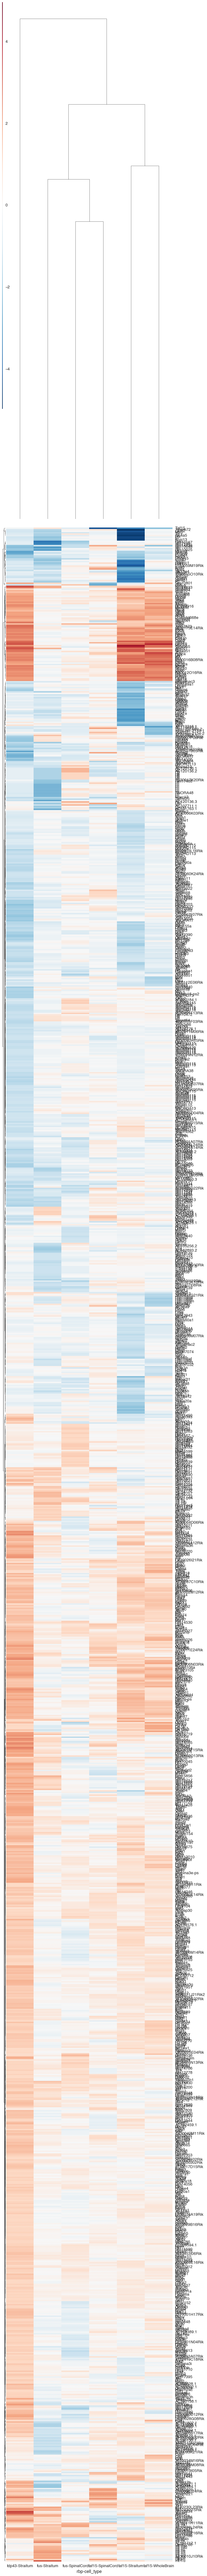

In [91]:
sns.clustermap(clustering_kds, linewidth=0, figsize=(10, 150))

#Create Network Analysis of bound and regulated genes

In [92]:
mouse_gene_id_names = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/mouse_gene_id_to_names.txt", index_col=0)
human_mouse_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=2)

known_rbps = pd.read_excel("nrg3813-s3.xls", "RBP table", index_col=2)
known_tfs = pd.read_excel("nrg3813-s4.xls", "human TFs", index_col=1)

known_tfs['gene_id'] = known_tfs.index
known_rbps['gene_id'] = known_rbps.index

known_tfs['mouse_gene_id'] = known_tfs.gene_id.apply(map_to_mouse)
known_rbps['mouse_gene_id'] = known_rbps.gene_id.apply(map_to_mouse)

known_tfs = known_tfs.dropna()
known_rbps = known_rbps.dropna()

known_tfs.index = known_tfs.mouse_gene_id
known_rbps.index = known_rbps.mouse_gene_id

known_tfs = known_tfs.join(mouse_gene_id_names)
known_rbps = known_rbps.join(mouse_gene_id_names)

known_tfs = known_tfs.groupby(level=0).first()
known_rbps = known_rbps.groupby(level=0).first()

In [93]:
with open("/nas3/gpratt/Dropbox/TAF15/Data/networks/straitum_rbp_network.csv", 'w')as fn, open("/nas3/gpratt/Dropbox/TAF15/Data/networks/straitum_node_attributes.csv", 'w') as node_attributes:

    for name, df in signifcant_downregulated.xs(u'Straitum', level="cell_type").groupby(level=["rbp"]): 
        if name == "tia1":
            continue
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("geneid"))) & set(known_rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            bound = "bound" if gene in all_bound_genes.ix[name] else "unbound"    
            node_attributes.write(",".join([mouse_gene_id_names.ix[gene][0], bound]) + "\n")
            fn.write(",".join([name, known_rbps.ix[gene]['gene name'], "downregulated", bound]) + "\n")
    print
    for name, df in signifcant_upregulated.xs(u'Straitum', level="cell_type").groupby(level=["rbp"]):
        if name == "tia1":
            continue
            
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("geneid"))) & set(known_rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            bound = "bound" if gene in all_bound_genes.ix[name] else "unbound" 
            node_attributes.write(",".join([mouse_gene_id_names.ix[gene][0], bound]) + "\n")
            fn.write(",".join([name, known_rbps.ix[gene]['gene name'], "upregulated"]) + "\n")

fus 113 1
taf15 171 1
tdp43 273 3

fus 60 1
taf15 95 9
tdp43 707 21


#Of the Co-differentall expressed RBPs how many of them actually overlap with binding sites?

In [94]:
protein_coding_genes = {key for key, value in gene_id_to_type.items() if value == "protein_coding"}

def fisher_exact_on_genes(regulated, bound, all_genes):

    not_regulated = protein_coding_genes - set(regulated)
    not_bound = protein_coding_genes - set(bound)

    bound_and_regulated = len(regulated & bound)
    bound_and_not_regulated = len(bound & not_regulated)
    not_bound_and_regulated = len(not_bound & regulated)
    not_bound_and_not_regulated = len(not_bound & not_regulated)

    
    counts = pd.Series({"bound_and_regulated": bound_and_regulated,
               "bound_and_not_regulated": bound_and_not_regulated,
               "not_bound_and_regulated": not_bound_and_regulated,
               "not_bound_and_not_regulated": not_bound_and_not_regulated,
               })
    
    test = scipy.stats.fisher_exact([[counts['bound_and_regulated'], counts['not_bound_and_regulated']], 
                                     [counts['bound_and_not_regulated'], counts['not_bound_and_not_regulated']]])
    
    counts['p_value'] = test[1]
    return counts

In [298]:
usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
upregulated_target_genes = {}
for regulated_name, df in signifcant_upregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        upregulated_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}
        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts
        
upregulated_df = pd.DataFrame(result).T
upregulated_df['fraction_bound_and_regulated'] = upregulated_df.bound_and_regulated / (upregulated_df.bound_and_regulated + upregulated_df.not_bound_and_regulated)
upregulated_df['fraction_not_bound_and_regulated'] = upregulated_df.bound_and_not_regulated / (upregulated_df.bound_and_not_regulated + upregulated_df.not_bound_and_not_regulated)

In [299]:
usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
unchanging_target_genes = {}
for regulated_name, df in unchanging_knockdowns.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        unchanging_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}
        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts
        
unchanging_df = pd.DataFrame(result).T
unchanging_df['fraction_bound_and_regulated'] = unchanging_df.bound_and_regulated / (unchanging_df.bound_and_regulated + unchanging_df.not_bound_and_regulated)
unchanging_df['fraction_not_bound_and_regulated'] = unchanging_df.bound_and_not_regulated / (unchanging_df.bound_and_not_regulated + unchanging_df.not_bound_and_not_regulated)

In [300]:
usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
downregulated_target_genes = {}

for regulated_name, df in signifcant_downregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        downregulated_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}

        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts

downregulated_df = pd.DataFrame(result).T
downregulated_df['fraction_bound_and_regulated'] = downregulated_df.bound_and_regulated / (downregulated_df.bound_and_regulated + downregulated_df.not_bound_and_regulated)
downregulated_df['fraction_not_bound_and_regulated'] = downregulated_df.bound_and_not_regulated / (downregulated_df.bound_and_not_regulated + downregulated_df.not_bound_and_not_regulated)

In [301]:
downregulated_df.p_value = downregulated_df.p_value * len(downregulated_df.p_value)
upregulated_df.p_value = upregulated_df.p_value * len(upregulated_df.p_value)
unchanging_df.p_value = unchanging_df.p_value * len(upregulated_df.p_value)


downregulated_df = downregulated_df.drop("uncatagorized", level=1)
upregulated_df = upregulated_df.drop("uncatagorized", level=1)
unchanging_df = unchanging_df.drop("uncatagorized", level=1)

downregulated_df['percent_bound_and_regulated'] = downregulated_df['fraction_bound_and_regulated'] * 100
downregulated_df['percent_not_bound_and_regulated'] = downregulated_df['fraction_not_bound_and_regulated'] * 100

upregulated_df['percent_bound_and_regulated'] = upregulated_df['fraction_bound_and_regulated'] * 100
upregulated_df['percent_not_bound_and_regulated'] = upregulated_df['fraction_not_bound_and_regulated'] * 100

unchanging_df['percent_bound_and_regulated'] = unchanging_df['fraction_bound_and_regulated'] * 100
unchanging_df['percent_not_bound_and_regulated'] = unchanging_df['fraction_not_bound_and_regulated'] * 100

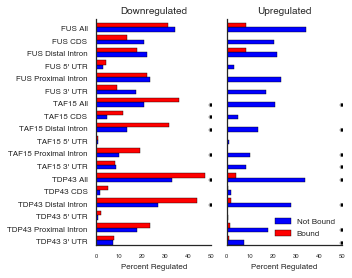

In [110]:
values = downregulated_df.percent_bound_and_regulated.values
ind = np.arange(len(values))
width = 0.35


with dataviz.Figure(os.path.join(img_dir, "binding_and_regulation_analysis.svg"), figsize=(5,4)) as fig:
    ax = fig.add_subplot(1,2,1)
    ax.barh(ind, list(reversed(list(downregulated_df.percent_not_bound_and_regulated))), 
            width, color='b', label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color='r', label="Bound")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(downregulated_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Downregulated", fontsize=10)
    ax.set_xlabel("Percent Regulated", fontsize=8)
    ax.set_yticks(ind + (width / 2))
    #ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_df.index])), fontsize=8)
    ax.set_yticklabels(list(reversed([" ".join([rbp_names[item[0]], all_regions[item[1]].replace("\n", " ")]) for item in upregulated_df.index])), fontsize=8)

    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)

    ax = fig.add_subplot(1,2,2)
    values = upregulated_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(upregulated_df.percent_not_bound_and_regulated))), 
            width, color='b', label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color='r', label="Bound")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(upregulated_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Upregulated", fontsize=10)
    ax.set_xlabel("Percent Regulated", fontsize=8)
    ax.set_yticklabels([])
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)



In [304]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration'

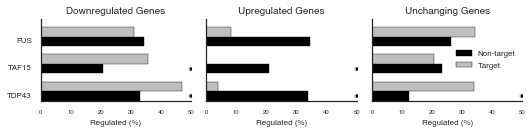

In [305]:
downregulated_all_df = downregulated_df.xs('all', level=1)
upregulated_all_df = upregulated_df.xs('all', level=1)
unchanging_all_df = unchanging_df.xs('all', level=1)

values = downregulated_all_df.percent_bound_and_regulated.values
ind = np.arange(len(values))
width = 0.35
num_rows = 1
num_cols = 3
target_color = 'k'
non_target_color = '.75'
with dataviz.Figure(os.path.join(img_dir, "binding_and_regulation_analysis_only_all.svg"), figsize=(2.5 * num_cols, 2.0 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    ax.barh(ind, list(reversed(list(downregulated_all_df.percent_not_bound_and_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="non target")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(downregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Downregulated Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=8)
    ax.set_yticks(ind + (width / 2))
    ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_all_df.index])), fontsize=8)

    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)

    ax = fig.add_subplot(num_rows, num_cols, 2)
    values = upregulated_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(upregulated_all_df.percent_not_bound_and_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="target")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(upregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Upregulated Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=8)
    ax.set_yticklabels([])
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(num_rows, num_cols, 3)
    values = unchanging_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(unchanging_all_df.percent_not_bound_and_regulated))), 
            width, color=target_color, label="Non-target")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="Target")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(unchanging_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Unchanging Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=8)
    ax.set_yticklabels([])
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)

#Get the actual genes that are bound and regulated, do go analysis, maybe print out the actual genes

In [100]:
def bound_and_regulated_regions(df):
    df = pd.DataFrame(pd.DataFrame(df).T.stack())
    df['region'] = df.index.get_level_values(level=1)
    combined = df.region.swaplevel(1,2).unstack().apply(lambda x: ",".join(x.dropna()), axis=1)
    df.index = df.index.droplevel(1)
    df['index'] = df.index 
    df = df.drop_duplicates(subset='index', take_last=True)
    df['merged_regions'] = combined
    df = df.drop(['region', 'index'], axis=1)
    return df

In [101]:
df = bound_and_regulated_regions(downregulated_target_genes)
df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/downregulated_bound_and_regulated.csv")
HTML(df.to_html())

In [102]:
df = bound_and_regulated_regions(upregulated_target_genes)
df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/upregulated_bound_and_regulated.csv")
HTML(df.to_html())

In [103]:
#Do the expressed gene background
downregulated_bound_and_regulated_go = {}
for name, series in downregulated_target_genes.items():
    downregulated_bound_and_regulated_go[name] = mm9go.enrichment(gencode_to_ensembl(series))
downregulated_bound_and_regulated_go = pd.concat(downregulated_bound_and_regulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()

upregulated_bound_and_regulated_go = {}
for name, series in upregulated_target_genes.items():
    upregulated_bound_and_regulated_go[name] = mm9go.enrichment(gencode_to_ensembl(series))
upregulated_bound_and_regulated_go = pd.concat(upregulated_bound_and_regulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()


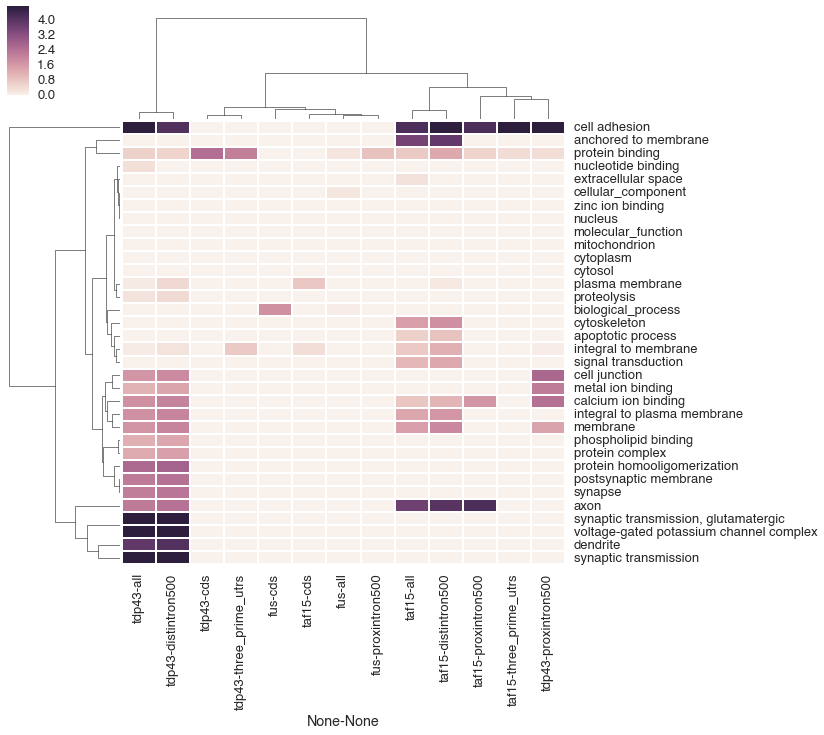

In [104]:
#cool polish this up a bit and maybe include
dataviz.plot_go_enrichment(downregulated_bound_and_regulated_go)

#Are genes that are bound and downregulated by taf15 and TDP43 overlapping? What about FUS?

In [105]:
regulated = signifcant_downregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0)

In [106]:
taf15_bound = set(binding_df.ix['taf15', 'all'].index) & protein_coding_genes
taf15_regulated = set(regulated.get_group("taf15").index.get_level_values(level=1)) & protein_coding_genes

fus_bound = set(binding_df.ix['fus', 'all'].index) & protein_coding_genes
fus_regulated = set(regulated.get_group("fus").index.get_level_values(level=1)) & protein_coding_genes

tdp43_bound = set(binding_df.ix['tdp43', 'all'].index) & protein_coding_genes
tdp43_regulated = set(regulated.get_group("tdp43").index.get_level_values(level=1)) & protein_coding_genes

taf15_bound_and_regulated = taf15_bound & taf15_regulated
fus_bound_and_regulated = fus_bound & fus_regulated
tdp43_bound_and_regulated = tdp43_bound & tdp43_regulated

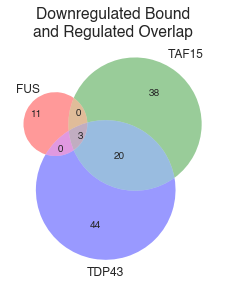

In [109]:
with dataviz.Figure(os.path.join(img_dir, "venn_binding_and_regulation_analysis_only_all.svg"), figsize=(4,4)) as fig:
    ax = fig.add_subplot(1,1,1)
    venn3([fus_bound_and_regulated, taf15_bound_and_regulated, tdp43_bound_and_regulated],
         set_labels=['FUS', 'TAF15', 'TDP43'],
         set_colors=[rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']], 
          ax=ax)
    ax.set_title("Downregulated Bound\nand Regulated Overlap")
    

There is a pretty good overlap bewteen bound and regulated genes for TAF15 and TDP43

#Motif Presence / Absence in peaks

In [128]:
CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['fus'], 
                                            'fus', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['taf15'], 
                                            'taf15', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['tdp43'], 
                                            'tdp43', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

In [180]:
def findMotifs(fasta, motif):
        

    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    handle, tmp_file = tempfile.mkstemp()
    with open(tmp_file, 'w') as handle:
        try:
            subprocess.call(["findMotifs.pl",
                             fasta,
                             "fasta",
                             "motifResults",
                             "-find", motif,
                             "-rna"], shell=False, stdout=handle
                           )

        except OSError:
            print "Homer not installed, ignoring motif generation, install homer for this to work"  
            raise
    return pd.read_table(tmp_file, index_col=0)

In [219]:
for rbp in assigned_peaks:
    print len(assigned_peaks[rbp]['all']['real'])

69596
155382
44507


In [267]:
all_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.motif"
#all_motif1_target, all_motif1_background, all_motif1_pvalue = get_homer_values(all_motif1_file)

utr3_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.motif"
#utr3_motif1_target, utr3_motif1_background, utr3_motif1_pvalue = get_homer_values(utr3_motif1_file)

all_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif"
#all_motif2_target, all_motif2_background, all_motif2_pvalue = get_homer_values(all_motif2_file)

utr3_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.motif"
#utr3_motif2_target, utr3_motif2_background, utr3_motif2_pvalue = get_homer_values(utr3_motif2_file)

In [220]:
#"GGTAAG.motif"
#"TCGGTGGT.motif"
result = {}
for rbp in assigned_peaks:
    for region in assigned_peaks[rbp]:
        print rbp, region
        print "fasta/{}.{}.{}.fa".format(rbp, region, 'real')
        try:
            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'real'), all_motif2_file)
            result[(rbp, region, "real", "GGTAAG")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": len(assigned_peaks[rbp][region]['real'])
                                             }

            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'random'), all_motif2_file)
            total_peaks = sum(len(bedtool) for bedtool in assigned_peaks[rbp][region]['rand'].values())
            result[(rbp, region, "random", "GGTAAG")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": total_peaks
                                             }
            
            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'real'), utr3_motif2_file)
            result[(rbp, region, "real", "TCGGTGGT")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": len(assigned_peaks[rbp][region]['real'])
                                             }

            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'random'), )
            total_peaks = sum(len(bedtool) for bedtool in assigned_peaks[rbp][region]['rand'].values())
            result[(rbp, region, "random",  "TCGGTGGT")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": total_peaks
                                             }
        except ValueError as e:
            print "no peaks in this likely"
motif_counts = pd.DataFrame(result).T

tdp43 three_prime_utrs
fasta/tdp43.three_prime_utrs.real.fa
tdp43 all
fasta/tdp43.all.real.fa
tdp43 five_prime_utrs
fasta/tdp43.five_prime_utrs.real.fa
tdp43 uncatagorized
fasta/tdp43.uncatagorized.real.fa
no peaks in this likely
tdp43 distintron500
fasta/tdp43.distintron500.real.fa
tdp43 cds
fasta/tdp43.cds.real.fa
tdp43 proxintron500
fasta/tdp43.proxintron500.real.fa
fus three_prime_utrs
fasta/fus.three_prime_utrs.real.fa
fus all
fasta/fus.all.real.fa
fus five_prime_utrs
fasta/fus.five_prime_utrs.real.fa
fus uncatagorized
fasta/fus.uncatagorized.real.fa
no peaks in this likely
fus distintron500
fasta/fus.distintron500.real.fa
fus cds
fasta/fus.cds.real.fa
fus proxintron500
fasta/fus.proxintron500.real.fa
taf15 three_prime_utrs
fasta/taf15.three_prime_utrs.real.fa
taf15 all
fasta/taf15.all.real.fa
taf15 five_prime_utrs
fasta/taf15.five_prime_utrs.real.fa
taf15 uncatagorized
fasta/taf15.uncatagorized.real.fa
no peaks in this likely
taf15 distintron500
fasta/taf15.distintron500.real.fa


In [221]:
motif_counts['percent_in_peak'] = (motif_counts.peaks_with_motif / motif_counts.total_peaks) * 100
motif_counts.index.names =['rbp', 'region', 'condition', 'motif']

In [230]:
ggtaag = motif_counts.xs("GGTAAG", level="motif").xs("all", level="region").percent_in_peak.unstack()

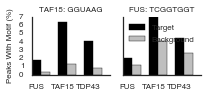

In [306]:
num_rows = 1
num_cols = 2
width=.35
ind = np.arange(len(ggtaag))

ggtaag = motif_counts.xs("GGTAAG", level="motif").xs("all", level="region").percent_in_peak.unstack()
with dataviz.Figure(os.path.join(img_dir, "motif_frequencies.svg"), figsize=(1.5 * num_cols,1.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    ax = fig.add_subplot(gs[0,0])

    ax.bar(ind, ggtaag.real, width, color=target_color, label="Target")
    ax.bar(ind + width, ggtaag.random, width, color=non_target_color, label="Background")
    
    ax.set_xticks(ind + (width / 2))
    ax.set_xticklabels([rbp_names[name] for name in ggtaag.index], fontsize=10)
    ax.set_title("TAF15: GGUAAG", fontsize=8)
    ax.set_ylabel("Peaks With Motif (%)", fontsize=8)

    ax.set_ylim(0,7)
    #ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)
    
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    

    ax = fig.add_subplot(gs[0,1])

    ax.bar(ind, tcggtggt.real, width, color=target_color, label="Target")
    ax.bar(ind + width, tcggtggt.random, width, color=non_target_color, label="Background")
    
    ax.set_xticks(ind + (width / 2))
    ax.set_xticklabels([rbp_names[name] for name in ggtaag.index], fontsize=10)
    ax.set_title("FUS: TCGGTGGT", fontsize=8)
    #ax.set_ylabel("% of Peaks With Motif", fontsize=8)

    ax.set_ylim(0,7)
    ax.set_yticklabels([])
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)
    
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
